# Document Intelligence Processor Walkthrough
This notebook walks through the Document Intelligence processor component that is included in this repository. It is useful for converting the raw API response from Document Intelligence into something more useful, and which can be easily converted into the format required for sending to an LLM endpoint.

Some features include:
* Automatic extraction of rich content in a PDF, including tables, figures and more.
* Output of text content in a PDF, images for each page and figure within the PDF, and pandas dataframes for tables within the PDF.
* Automatic correction of image rotation when extracting page and figure images (if not corrected, this can completely destroy LLM extraction accuracy)
* Custom definition of the content outputs, allowing for completely dynamic formatting of all content in a file.
* Chunking of content into smaller parts (e.g. into chunks of X pages) which can then be processed as part of a Map Reduce pattern.
* Automatic conversion of the content to the OpenAI message format, ready for processing with an LLM.

In [56]:
import json
import os
from dataclasses import dataclass

from IPython.display import Markdown as md
from dotenv import load_dotenv
from azure.core.credentials import AzureKeyCredential
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.ai.formrecognizer import DocumentAnalysisClient, AnalysisFeature
from azure.ai.formrecognizer import AnalyzeResult as FormRecognizerAnalyzeResult
from azure.ai.documentintelligence.models import (
    AnalyzeResult,
    AnalyzeDocumentRequest,
    DocumentAnalysisFeature,
)

# ignore cryptography version warnings
import warnings
warnings.filterwarnings(action='ignore', module='.*cryptography.*')

# Append src module to system path to import from src module
import sys
sys.path.append(os.path.abspath("../function_app"))

from src.components.doc_intelligence import (
    DefaultDocumentPageProcessor, DefaultDocumentKeyValuePairProcessor,
    DefaultDocumentTableProcessor, DefaultDocumentFigureProcessor,
    DefaultDocumentParagraphProcessor, DefaultDocumentLineProcessor,
    DefaultDocumentWordProcessor, DefaultSelectionMarkFormatter,
    DefaultDocumentSectionProcessor, DocumentIntelligenceProcessor, 
    PageDocumentListSplitter, convert_processed_di_docs_to_openai_message,
    convert_processed_di_docs_to_markdown,
)
from src.helpers.data_loading import load_pymupdf_pdf, extract_pdf_page_images

# Load environment variables
load_dotenv(override=True)

# Auto-reload modules
%load_ext autoreload
%autoreload 2

# Display all outputs of a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Set Constants and Define the Configuration

In [107]:
# Select whether to use the Preview Document Intelligence version (v4.0) or the GA version (v3.3). Each version has some slight differences
# - V4.0 is in preview and is only available in a handful of regions. It has some additional features, particularly the ability to process figures within an image.
# - V3.3 is Generally Available and available in most Azure regions. It does not have support for extracting/processing figures from within an image.
USE_DOC_INTEL_PREVIEW_VERSION = False

# Select the model type. 
# More info here: https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/model-overview
DOC_INTEL_MODEL_ID = "prebuilt-layout" # E.g. "prebuilt-read", "prebuilt-layout", or "prebuilt-document"

# Possible Document Intelligence features
# v4.0 (Preview): ['ocrHighResolution', 'languages', 'barcodes', 'formulas', 'keyValuePairs', 'styleFont', 'queryFields']
# v3.3 (GA):      ['ocrHighResolution', 'languages', 'barcodes', 'formulas', 'styleFont']

DOC_INTEL_FEATURES = ['ocrHighResolution', 'languages', 'barcodes', 'formulas']

### Load environment variables and setup the Document Intelligence client

In [113]:
# Load environment variables from Function App local settings file
with open("../function_app/local.settings.json", "rb") as f:
    local_settings = json.load(f)
    os.environ.update(local_settings["Values"])

DOC_INTEL_ENDPOINT = os.getenv("DOC_INTEL_ENDPOINT")
DOC_INTEL_API_KEY = os.getenv("DOC_INTEL_API_KEY")

# Construct the Document Intelligence clients
if USE_DOC_INTEL_PREVIEW_VERSION:
    # Doc Intelligence v4.0 (preview) - only available in selected regions
    di_client = DocumentIntelligenceClient(
        endpoint=DOC_INTEL_ENDPOINT, 
        credential=AzureKeyCredential(DOC_INTEL_API_KEY),
        api_version="2024-07-31-preview",
    )
    enabled_features = [DocumentAnalysisFeature(feature) for feature in DOC_INTEL_FEATURES]
else:
    # Doc Intelligence v3.3 (GA) - Available globally
    di_client = DocumentAnalysisClient(
        endpoint=DOC_INTEL_ENDPOINT, 
        credential=AzureKeyCredential(DOC_INTEL_API_KEY),
        api_version="2023-07-31",
    )
    enabled_features = [AnalysisFeature(feature) for feature in DOC_INTEL_FEATURES]
print("Selected Document Intelligence Features:", [feature.value for feature in enabled_features])

Selected Document Intelligence Features: ['ocrHighResolution', 'languages', 'barcodes', 'formulas', 'styleFont']


In [114]:
# Define helper objects/functions
from typing import Union

@dataclass
class SamplePdfFileInfo:
    name: str
    description: str
    url_source: str

def get_analyze_document_result(
    sample_pdf_file_info: SamplePdfFileInfo,
    di_client: Union[DocumentIntelligenceClient, DocumentAnalysisClient],
    model_id: str = "prebuilt-layout",
    **kwargs
) -> Union[AnalyzeResult, FormRecognizerAnalyzeResult]:
    """
    Gets the AnalyzeResult for a sample PDF file using a Document Intelligence
    client.
    """
    if isinstance(di_client, DocumentIntelligenceClient):
        poller = di_client.begin_analyze_document(
            model_id=model_id,
            analyze_request=AnalyzeDocumentRequest(url_source=sample_pdf_file_info.url_source),
            **kwargs
        )
        new_result = poller.result()
    else:
        poller = di_client.begin_analyze_document_from_url(
            model_id=model_id,
            document_url=sample_pdf_file_info.url_source,
            **kwargs
        )
        new_result = poller.result()
    return new_result

# Setup a list of PDFs for testing
We will use a set of PDFs for showcasing how the processor works. These examples include different elements such as tables, inline figures, document structures/heirarchies, and lengths/pages. You can add your own files here for testing.

In [115]:
# Get raw file links
doc_intelligence_test_files = {
    "ikea": SamplePdfFileInfo(
        name="IKEA Installation Manual",
        description=(
            "An instruction manual for installing an Ikea kitchen. "
            "This document contains 12 pages, consisting of a series of diagrams and written instructions. "
            "This shows how we can extract individual figures and text from the document."
        ),
        url_source="https://www.ikea.com/au/en/files/pdf/c7/ef/c7ef4878/kitchen-installation-guide_fy22.pdf",
    ),
    "rotated_image_pdf": SamplePdfFileInfo(
        name="Rotated Image PDF",
        description=(
            "A single-page PDF containing an embedded image. "
            "This document Shows how we can automatically extracted images from a PDF, "
            "correcting the rotation of the page and figures images automatically."
        ),
        url_source="https://github.com/pymupdf/PyMuPDF/blob/main/tests/resources/test_delete_image.pdf?raw=true",
    ),
    "editorial_page": SamplePdfFileInfo(
        name="Editorial Page (Mixed content)",
        description=(
            "A single-page editorial article with a mix of text and figures on the page. "
            "Another example  extracting both text and figures from the page."
        ),
        url_source="https://github.com/pymupdf/PyMuPDF/blob/main/tests/resources/001003ED.pdf?raw=true",
    ),
    "multicolumn_pdf": SamplePdfFileInfo(
        name="Multicolumn PDF with table",
        description="A 3-page test PDF containing multi-column text and a table to be extracted.",
        url_source="https://github.com/py-pdf/sample-files/blob/main/026-latex-multicolumn/multicolumn.pdf?raw=true",
    ),
    "rotated_proof_of_delivery_pdf": SamplePdfFileInfo(
        name="Rotated Delivery Receipt",
        description="A 3-page test PDF containing multi-column text and a table to be extracted.",
        url_source="https://github.com/Azure/multimodal-ai-llm-processing-accelerator/blob/main/demo_app/demo_files/Rotated%20Proof%20of%20Delivery%20Receipt.jpg?raw=true",
    ),
}

# Print file links
print("Sample PDF files to analyze:")
for name, sample_pdf_file_info in doc_intelligence_test_files.items():
    print(f"- '{name}': {sample_pdf_file_info.description}")

Sample PDF files to analyze:
- 'ikea': An instruction manual for installing an Ikea kitchen. This document contains 12 pages, consisting of a series of diagrams and written instructions. This shows how we can extract individual figures and text from the document.
- 'rotated_image_pdf': A single-page PDF containing an embedded image. This document Shows how we can automatically extracted images from a PDF, correcting the rotation of the page and figures images automatically.
- 'editorial_page': A single-page editorial article with a mix of text and figures on the page. Another example  extracting both text and figures from the page.
- 'multicolumn_pdf': A 3-page test PDF containing multi-column text and a table to be extracted.
- 'rotated_proof_of_delivery_pdf': A 3-page test PDF containing multi-column text and a table to be extracted.


## Define Document Intelligence Processor configuration
Now we will define the configuration for the processing of the result for Doc Intelligence.

Document Intelligence returns many different element objects which correspond to different types of content in the document. Some examples are pages, sections, paragraphs, lines, words, figures, tables and more. Each of these elements have a corresponding processor which is designed to handle that type of element. These processors may simply format the output (e.g. for paragraphs and lines), but others may perform data processing to load and convert the raw API response into something more usable.

Here are some key things to look at:

##### 1. Processed output dataclass type (Haystack `Document`s)
Because the resulting information comes in different types (e.g. text, images, or dataframes), the processors use Haystack's Document dataclass as the standardised data structure for storing the content. These can then be post-processed into other formats such as OpenAI message dictionaries.

##### 2. Formatting text content
When outputting text, the format of that text can be customized using the `*_text_formats` parameters of each element processor. The format can be defined such that different elements are returned in a specific format (such as italicing text or adding prefixes or suffixes). The format can feature placeholders for different parts of the content, with the list of possible placeholders shown in the constructor docstring for each processor class. 
* If the processor processes an element that does not contain any information for the placeholder, that format will be skipped. 
* For example, if the text formats for a figure processor was ["*Figure Caption:* {caption}", "*Figure Footnotes:* {footnotes}", "*Figure Content:*\n{content}"] but the figure did not have any captions or footnotes, only the final text_format string would be returned in the result. 
* Final result: "*Figure Content:\n<text_extracted_from_inside_the_image>"

##### 3. Outputting and rotating images
The Page and Figure processors can automatically output page and figure images into the output, maintaining the correct order of the content. These processors can also automatically adjust the rotation of the image using the `angle` of the page as detected by Document Intelligence. This can ensure that all output images are rotated correctly prior to storing and using those images (this makes a big difference in how accurately LLM's can analyze those images).

##### 4. Splitting output `Document`s into chunks
When processing large documents, it can be useful to split the original document into separate chunks prior to processing. While the processors are not meant to completely replace other chunking tools (e.g. those in `Langchain` and other libraries), most chunkers are only designed to work with text content and will break if they are given multimodal data. To help avoid this, a `Splitter` can be used to split processed results. The default option is the `PageDocumentListSplitter`, which can split the list of full outputs into chunks based on the page number of the original content. This is useful in cases where you want to take a large Document (e.g. 50+ pages) and process those the document in chunks, then combine the chunk results into a final document-level result. This is a common pattern in document processing (known as the Map Reduce pattern).

##### 5. Merging output `Document`s 
By default, each individual element within a document will result in 1 or more outputs. This means that a single page of paragraphs, lines or words would result in many different output `Document`s. Converting these to LLM messages would then result in hundreds of messages for each document. To prevent this, we can merge adjacent text elements together to reduce the number of text objects prior to converting them into LLM messages. This is accomplished with the 
* Example result:
* Original documents: [text, text, image, text, text, text, table (markdown), text, image]
* Merged documents: [text, image, text, image]

In [109]:
### Document Intelligence Processor config

# Define processors for individual components
selection_mark_formatter = DefaultSelectionMarkFormatter(
    selected_replacement="[X]", 
    unselected_replacement="[ ]"
)
section_processor = DefaultDocumentSectionProcessor(
    text_format=None,
)
page_processor = DefaultDocumentPageProcessor(
    page_start_text_formats=["\n*Page {page_number} content:*"],
    page_end_text_formats=None,
    page_img_order="after",
    page_img_text_intro="*Page {page_number} Image:*",
    img_export_dpi=100,
    adjust_rotation = True,
    rotated_fill_color = (255, 255, 255),
)
table_processor = DefaultDocumentTableProcessor(
    before_table_text_formats=["**Table {table_number} Info**\n", "*Table Caption:* {caption}", "*Table Footnotes:* {footnotes}", "*Table Content:*"],
    after_table_text_formats=None,
)
figure_processor = DefaultDocumentFigureProcessor(
    before_figure_text_formats=["**Figure {figure_number} Info**\n", "*Figure Caption:* {caption}", "*Figure Footnotes:* {footnotes}", "*Figure Content:*\n{content}"],
    output_figure_img=True,
    figure_img_text_format="*Figure Image:*",
    after_figure_text_formats=None,
)
key_value_pair_processor = DefaultDocumentKeyValuePairProcessor(
    text_format = "*Key Value Pair*: {key_content}: {value_content}",
)
paragraph_processor = DefaultDocumentParagraphProcessor(
    general_text_format = "{content}",
    page_header_format = None,
    page_footer_format = None,
    title_format = "\n{heading_hashes} **{content}**",
    section_heading_format = "\n{heading_hashes} **{content}**",
    footnote_format = "*Footnote:* {content}",
    formula_format = "*Formula:* {content}",
    page_number_format = None,
)
line_processor = DefaultDocumentLineProcessor()
word_processor = DefaultDocumentWordProcessor()

# Now construct the DocumentIntelligenceProcessor class which uses each of these sub-processors
doc_intel_result_processor = DocumentIntelligenceProcessor(
    page_processor = page_processor,
    section_processor = section_processor,
    table_processor = table_processor,
    figure_processor = figure_processor,
    paragraph_processor = paragraph_processor,
    line_processor = line_processor,
    word_processor = word_processor,
    selection_mark_formatter = selection_mark_formatter
)

# Now construct the a splitter class which can separate the outputs into different chunks
chunk_splitter = PageDocumentListSplitter(pages_per_chunk=3)

# Process Documents
We will now process our documents, inspecting the result and converting it into various formats.

==================== PROCESSING TEST PDF: 'ikea' =========================

Reusing DI result
Output info:

- Number of pages in the file: 12
- Number of content Documents: 248
- Number of content Documents after merging adjacent text Documents: 24
- Number of content chunks after splitting the Documents by page: 4

Printing the content in markdown format
*** Chunk 1 Content ***


*Page 1 content:*


 **A guide to installing a new METOD Kitchen**


 **METOD Kitchen installation guide**

This guide provides step-by-step instructions on how to install your new IKEA METOD kitchen.

[ ]

[ ] [ ]

[ ] [ ]

[ ]

[ ]

[ ]

[ ]

[ ]

[ ]

[ ]

[ ]

[ ]

[ ]

[ ]

8 00

O [ ]

===---

---== =

IKEA

[ ]

[ ]

[ ]

[ ]




*Page 1 Image:*

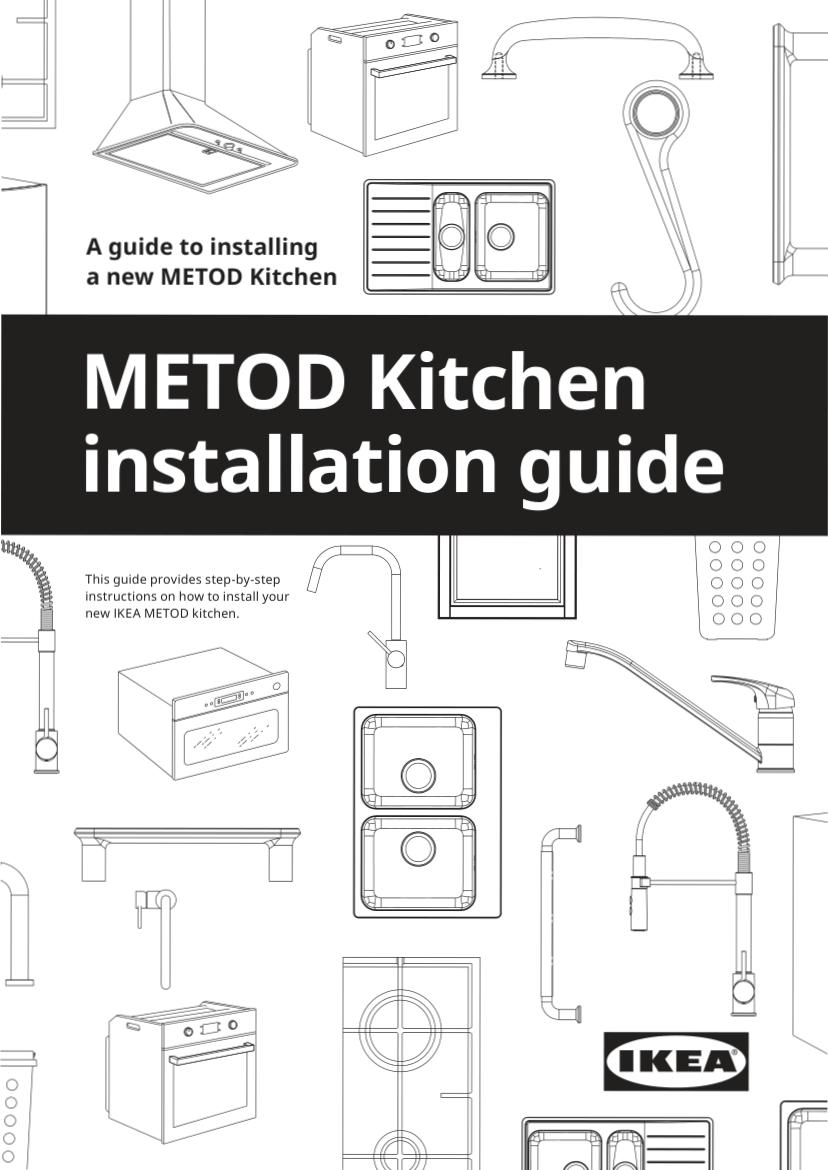


*Page 2 content:*


 **Step-by-step guide**


 **Installing your new IKEA kitchen**

This brochure is your guide to preparing and installing your new kitchen. Inside you'll find steps to follow and useful tips and ideas. Use this guide and your IKEA assembly instructions to make sure your kitchen is installed in the right way.


 **Before you begin**

Go through this brochure before you begin the installation, to see what stages are involved and the tools you'll need. To make sure you have all the components you need, compare the packages and parts against your order list and the freight list. You should only dismantle your old kitchen once you have all your new parts and appliances. Your kitchen parts and benchtop should be stored indoors, in normal room temperature and humidity.

Before you remove your old kitchen make sure that your electricity, gas and water is shut off. Use a qualified trades professional to disconnect and reconnect your gas, water and electricity.


 **You can do it yourself, but you don't have to**

Although our kitchens are designed to be as simple as possible for you to assemble and install yourself, it is important to consider all aspects of a kitchen renovation. Some key steps, such as wall cabinet installation or cutting the benchtop, require more skill and expertise than others.

We can offer you services ranging from planning and delivery to complete kitchen installation. For more details see the back page of this guide, the kitchen section of IKEA.com.au or visit your local IKEA store.

Once your kitchen arrives, check off your delivery to see that everything is in order.

[ ]

-

-

IKEA Design and Quality

IKEA of Sweden




*Page 2 Image:*

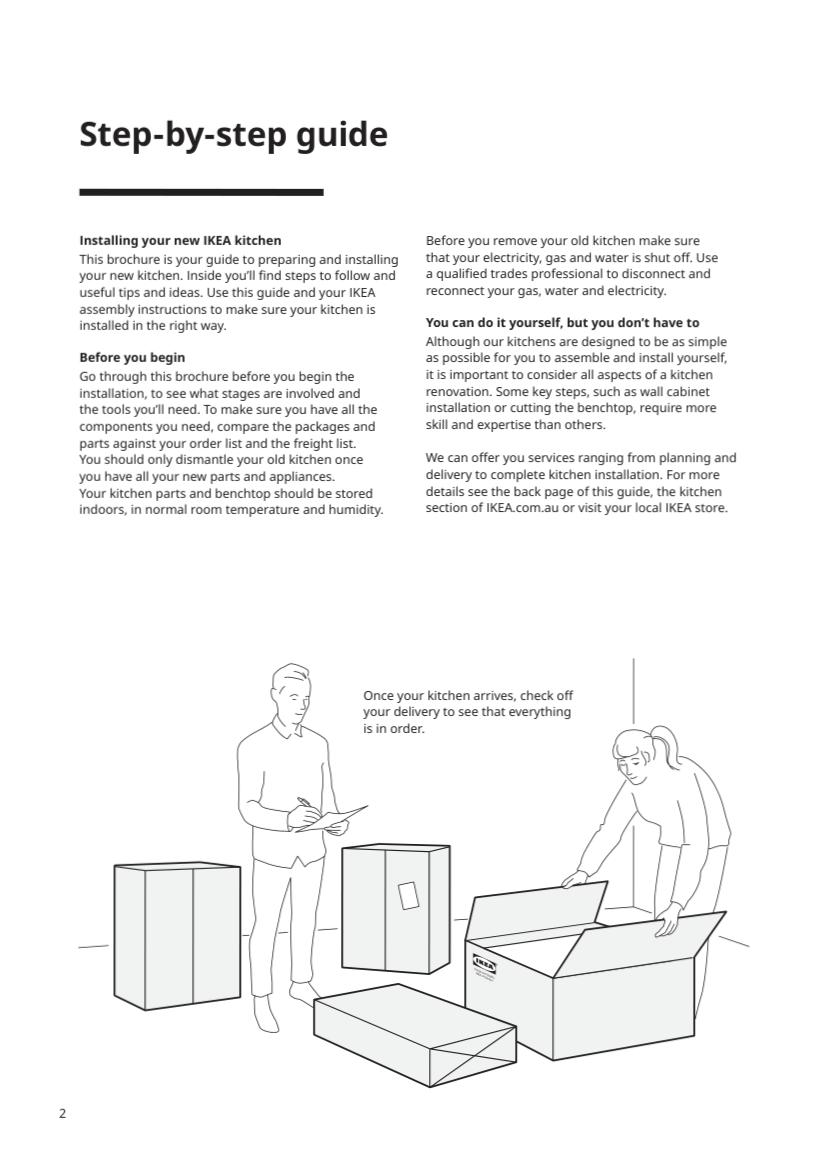


*Page 3 content:*


 **Tools and materials**

Below is a summary of the basic tools you'll need. In addition you'll find which tools to use for each product in their respective assembly instructions. It's a good idea to wear safety glasses when using power tools.


 **Good to know**

Plaster, wood or concrete walls? Because there are many different types of walls, fixing hardware is not supplied with your cabinets. Most hardware or home improvement stores stock appropriate fixing hardware and can help you choose the right sort for your walls.

Spirit level


 **Fine-toothed handsaw**

G clamps

1


 **Mitre box and saw**

Flat screwdriver

Phillips screwdriver

1

Awl

Pencil

Measuring tape

Electric drill/ screwdriver

Try square

O

Jigsaw

Hammer

Rubber hammer

Circular saw

Hole cutter for drilling the hole for the mixer tap in the sink, Ø35mm FIXA 2-piece tool set $15 901.768.20




*Page 3 Image:*

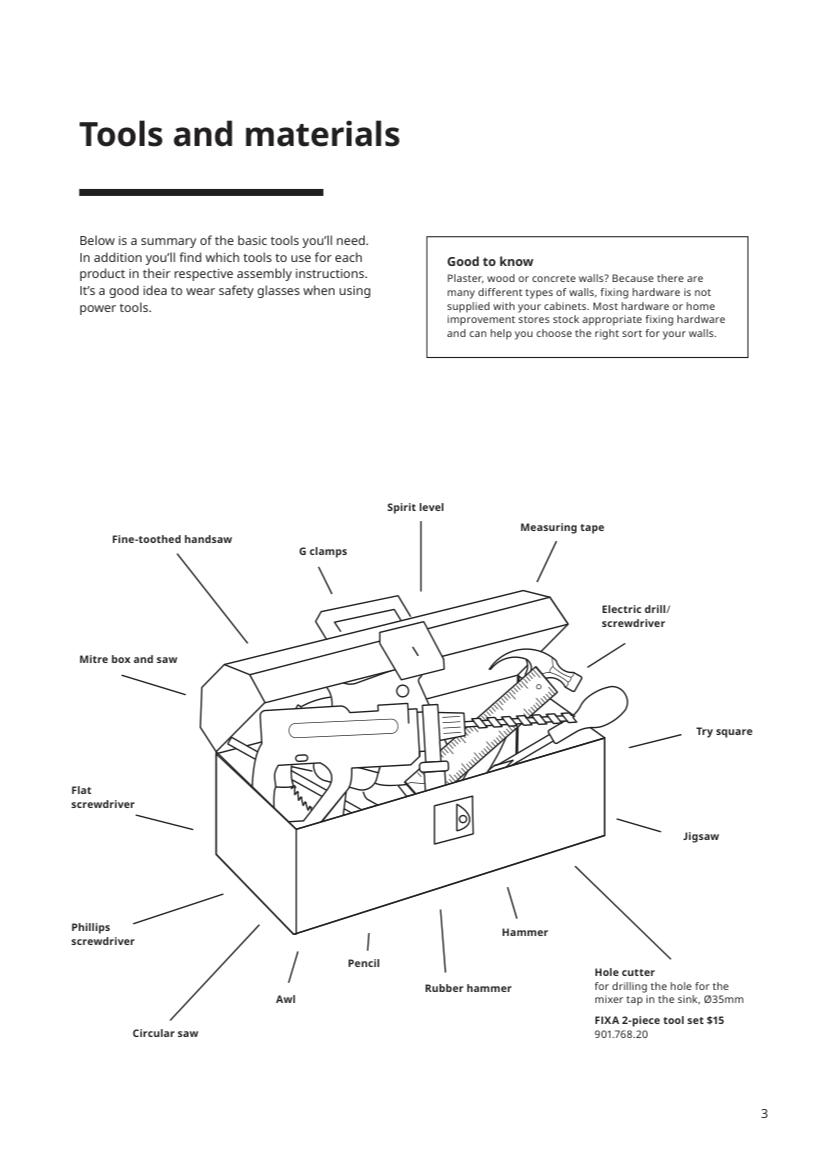

*** Chunk 2 Content ***


*Page 4 content:*


 **Preparing your room**

Once you've removed your old kitchen, prepare the room by making sure your walls and floors are even, and the walls are suitable for supporting your new kitchen. Now is also the time to prime and paint walls, put tiles on the walls/floors or change your flooring.

Prepare your space by making sure your corners are even and your walls and floor are straight. Use your try square for the corners and a spirit level for the walls and floor.


 **Marking cabinet positions**

Draw a layout of your new kitchen directly on the wall. Check that everything fits with the measurements from your plan, and that electricity, water, gas and ventilation connections are where you want them to be. Also mark where to fasten your new kitchen's suspension rails.

10

Make sure you note the highest point of the floor and where the corners aren't 90 degrees.

[X] Make sure you leave 82cm between the highest point of your floor and the bottom of your base suspension rail.

Check your wall is strong enough to hang your suspension rail and cabinets. Depending on your wall material, it's best to install your rail onto a stud or a support beam. Using an electronic stud finder can be helpful.

X

Double-check your plumbing is where you want it and fits with your layout plan.




*Page 4 Image:*

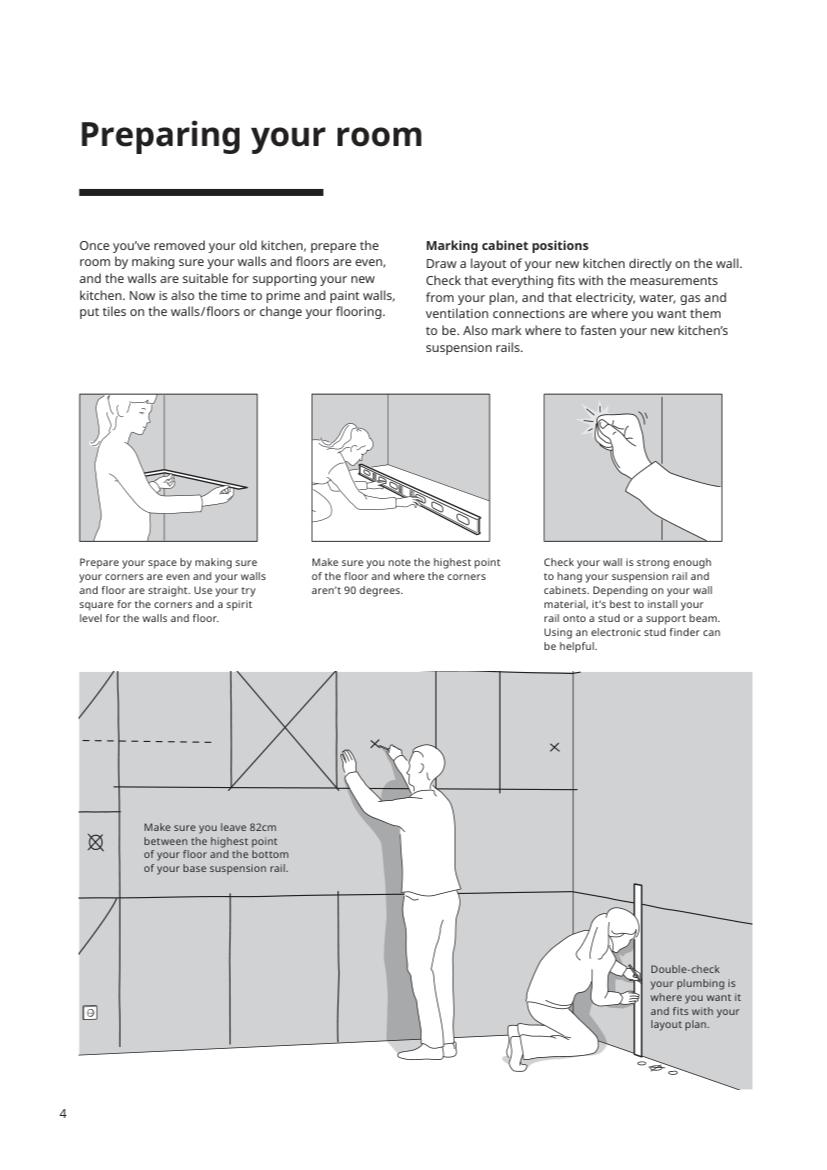


*Page 5 content:*


 **Mounting the suspension rails**

Your new IKEA cabinets can be hung directly onto a suspension rail making them easier to install and adjust. It's important to make sure your suspension rail is straight and level, and to secure it with the right screw type for your wall.

0

0

[X]

0

0 0

0

O

Fasten your rails, base cabinet rails first. Make sure you've found suitable points in the wall where the rails can be fastened, and that the rails are level before drilling.

If your wall is uneven use distancers between the rail and the wall to make sure the rail is straight.

Use a spirit level to check that each rail is level.

Kitchen height 208 cm

-* - +

-X

X

Wall cabinet height 60cm

202cm

X

×

[X]

A

82cm

Base cabinet height 80cm

X

X

Plinth height 8cm

B

Mount the rails at the right height

The underside of the base cabinet suspension rail (A) should be 82cm above your floor's highest point (B). If your kitchen is 208cm high, allow 120cm between the underside of the base cabinet suspension rail and the underside of the rail for the wall/high cabinet. If the kitchen is 228cm or 248cm high you should allow 140cm or 160cm respectively.




*Page 5 Image:*

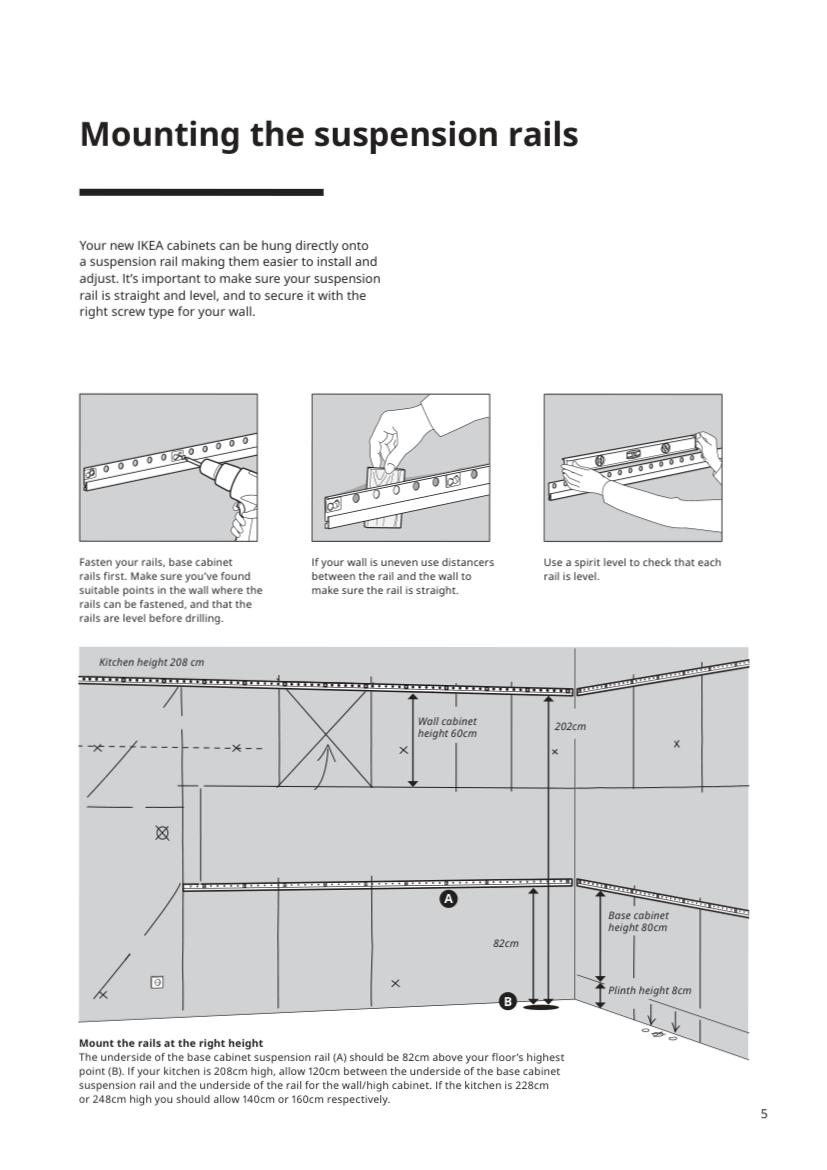


*Page 6 content:*


 **Installing your cabinets**

In most kitchens it's best to install your wall cabinets first. This way you have room to move without base cabinets in the way. One exception is if you're installing a single line kitchen with a high cabinet at one end. In this case install the high cabinet first.

Some cabinets have ready-made openings for utilities and plumbing, but you can use a jigsaw to create your own openings if needed. Do this before fitting the cabinet. Be aware of where you place openings as it can affect how you can arrange drawers in a cabinet.

7

/

Assemble all wall cabinet frames according to the assembly instructions. Wait until later before fitting drawers, doors and internal fittings.

Hang the corner cabinet first and secure by tightening the screws. Hang the remaining cabinets and connect them with the included screws. Wait to tighten the screws until the base cabinets are in place and you can ensure alignment.

Assemble all base cabinets according to the assembly instructions. Make sure to have the legs attached in the order the cabinets will be fitted.

120000

Hang your base cabinets starting in the corner. Hang each following cabinet in the same way. If you're installing a corner carousel now is the time to do it.

Cabinet legs connecting two cabinets can be used to support both cabinets while you're installing. Remember to use the distance ring included with the legs.

0

0

0

0

0

0

0

0

Make sure the right base cabinet is aligned with your plumbing.

Check that each cabinet is aligned with the previous cabinet by adjusting the legs.

If you're using a high cabinet, fit with a cover panel first.




*Page 6 Image:*

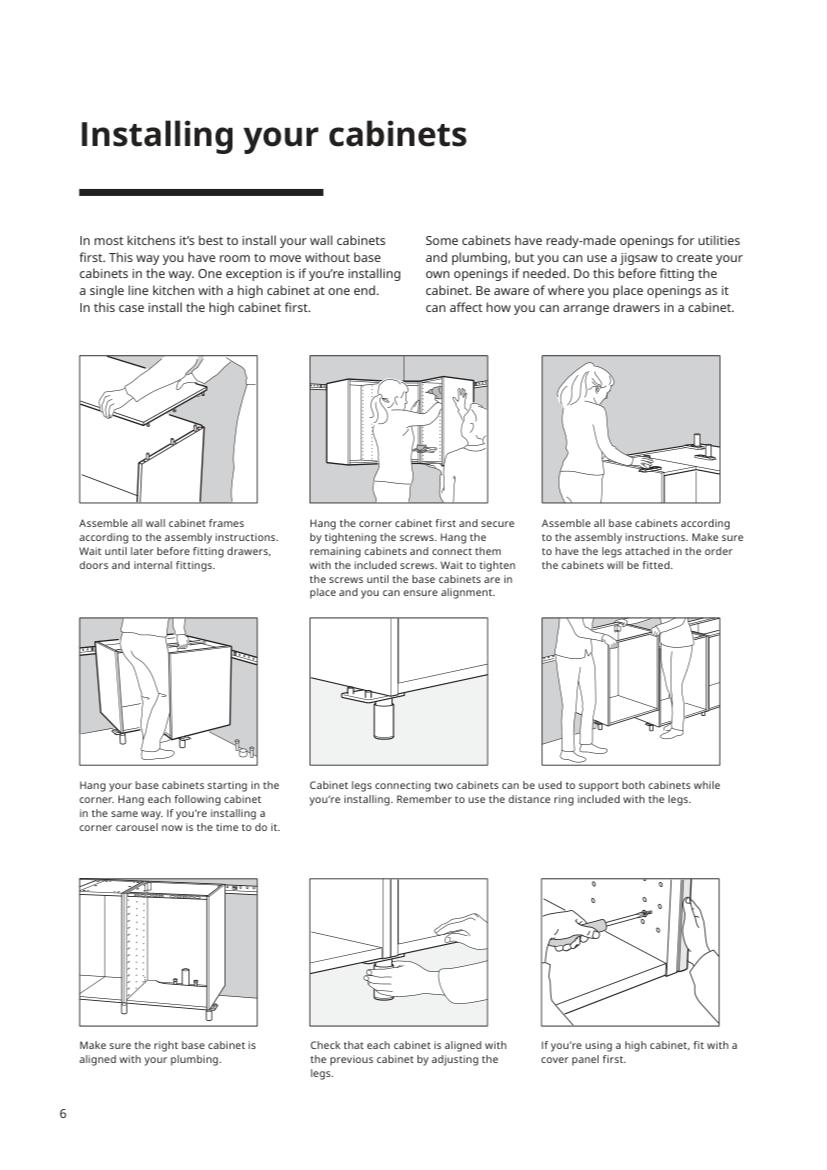

*** Chunk 3 Content ***


*Page 7 content:*

-

-

Filler pieces Filler pieces are used between your cabinets and walls for a streamlined appearance, and to ensure there is enough room to fully open doors and drawers. They're especially useful if your walls aren't perfectly straight.

0

-

-

Check the wall with your spirit level to see if it is straight. If the wall is even, measure between the wall and the cabinet and mark this distance at the top and bottom of the filler piece.

If the wall isn't level and flat, the filler piece must be cut to fit to the wall's shape. To do this, you'll need a filler piece, measuring tape, small block of wood about 2.5-3.5cm thick and pencil. Cut the filler piece so it's the same height as the cabinet. Place the edge of the filler piece against the wall. Hold the block of wood flat against the wall with the pencil against it. Keep them pressed against the wall as you slide them down the length of the filler piece. Now you have traced the shape of the wall onto the filler piece. Cut along your trace line.

Place the newly cut edge of the filler piece against the wall -it should fit perfectly. Mark the edge of the cabinet on the top and bottom of the filler piece. Draw a straight line from these points and cut.

If you're going to install a high cabinet, don't make final adjustments or fully tighten the screws until you have installed all the other cabinets as well.

To ensure the filler piece stays in place, first fasten a support strip to the wall. Drill holes in the cabinet for the screws you'll use to fasten the cabinet and filler piece together. Put the filler piece into place. Put screws through the holes you have drilled. When all your filler pieces are in, caulk around each one with silicone for an airtight seal.




*Page 7 Image:*

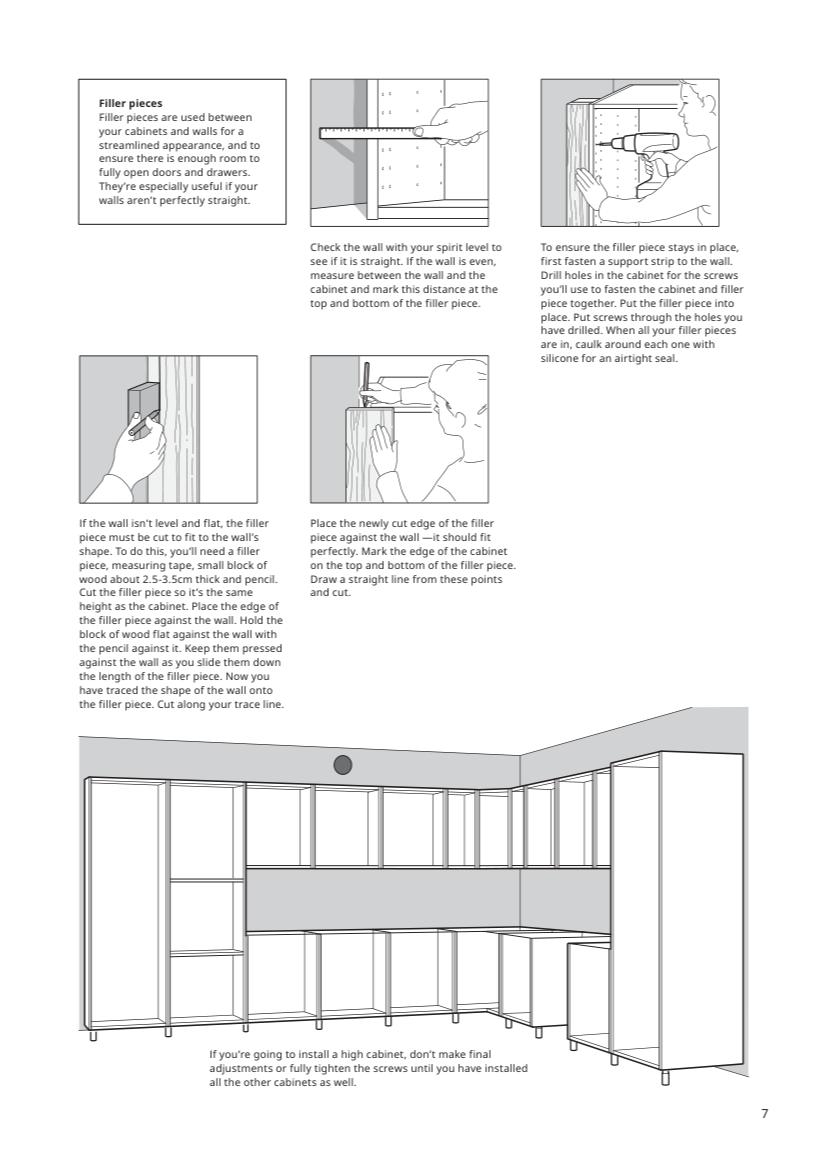


*Page 8 content:*


 **Installing your benchtop, sink, lighting and appliances**

With your cabinet frames in, it's time to install your benchtop, sink, lighting and appliances. Check that your benchtop is the correct size before fitting it in place. Now is also the time if you need to customise your benchtop for a sink or cooktop.

Note: Always use your assembly instructions for help.

Once your benchtop is in, you're ready to get your water, gas, lighting and appliances connected. All water, gas and electricity connections must be done by qualified professionals according to valid local safety regulations.

!

!

All electrical connections must be made by a qualified electrician.

Install your lighting and appliances. If drilling holes, use a piece of wood to meet the drill as it penetrates the surface to avoid the edges from splintering.

Proof measure your benchtop. If you have a pre-cut benchtop now is the time to cut it to the right length. Cut with the benchtop underside facing up if you are using a buzz or jigsaw, but with the top facing up if using a handsaw.

Use a circular saw and G clamps to hold a straight-edge to your pre-cut benchtop when you cut to customise the size. It's useful to use a pair of sawhorses to help you. A tip is to have a second person holding the piece to be cut off to prevent the edge from splintering.

Mark a spot for the sink by laying the benchtop in place. Trace the inside of the base cabinet onto the underside of the benchtop. This helps you align your sink. Turn your benchtop over and trace the outline of your sink onto masking tape.

Use a jigsaw to cut out space for your sink. It's helpful to drill a hole on the inside corners of your outline before cutting, so you can make a cleaner cut.

To prevent moisture from penetrating the benchtop apply polyurethane silicone across the sawn edges.

Install the sink into the benchtop according to the assembly instructions.

Secure your benchtop in place according to the assembly instructions.




*Page 8 Image:*

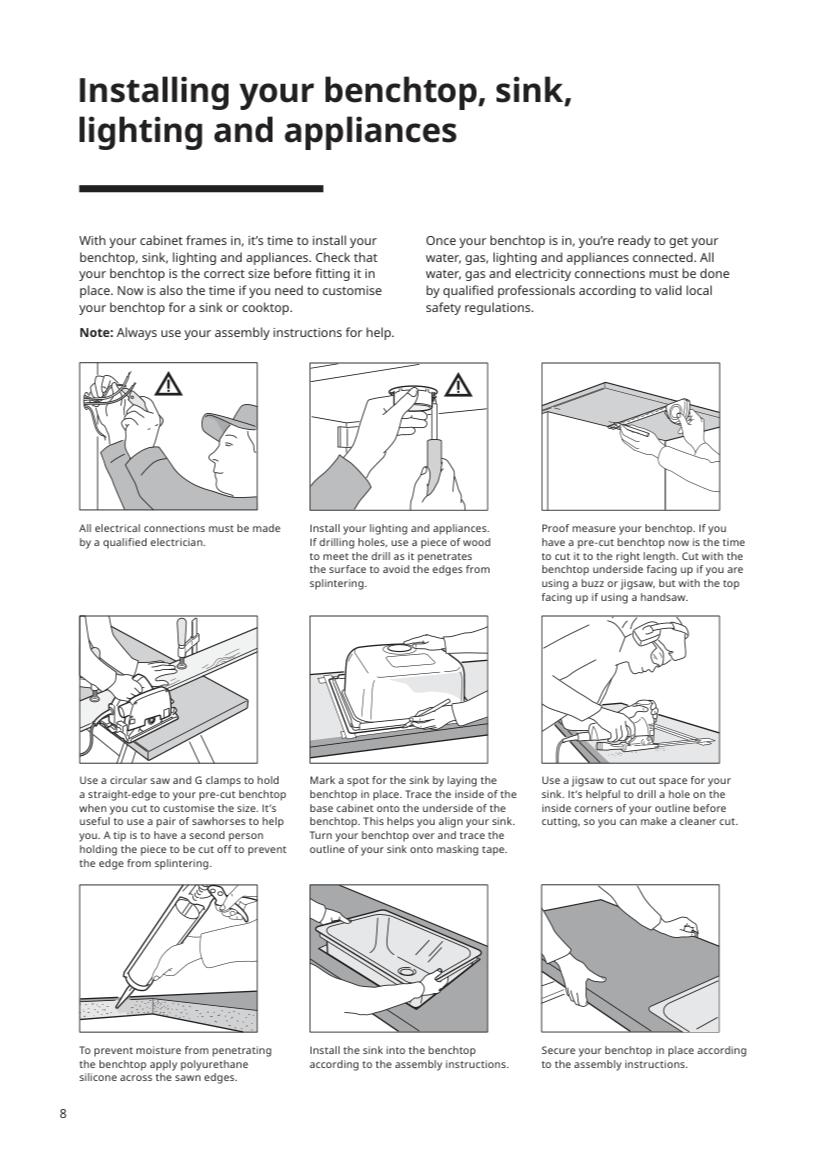


*Page 9 content:*

Customise your benchtop for your cooktop in the same way as for your sink. Refer to the assembly instructions for the cooktop as a guide.

Install the rangehood. IKEA rangehoods can be installed in two ways: either ducted to the outside, called extraction; or used in recirculation mode fitted with a charcoal filter. Each installation option is described in the assembly instructions that come with the product.

Saw the hole either in the back panel or in the top of the cabinet, following the assembly instructions. For safety and functionality, use the exact measurements that are recommended in the instructions for installation of the rangehood.

[ ] C

[ ] [ ]


 **Kitchen island**

If you're planning for a kitchen island we have supporting brackets to fasten it firmly to the floor. Legs/plinths must then be fitted around the outside of the island.

You can use either UTBY legs or the METOD assembly kit for kitchen island. The latter is used to connect cabinets back to back, or for attaching a cover panel to the back of cabinets.


 **Contact your local IKEA store if you need help regarding the assembly.**


 **METOD assembly kit for kitchen island $15**


 **Good to know**

If you're installing a kitchen island, it must be secured to the floor using UTBY legs or by building a plinth frame. Fasten the plinth frame to both the floor and the cabinets. When attaching the frame to the floor take care to avoid existing amenities like floor heating or plumbing already installed.




*Page 9 Image:*

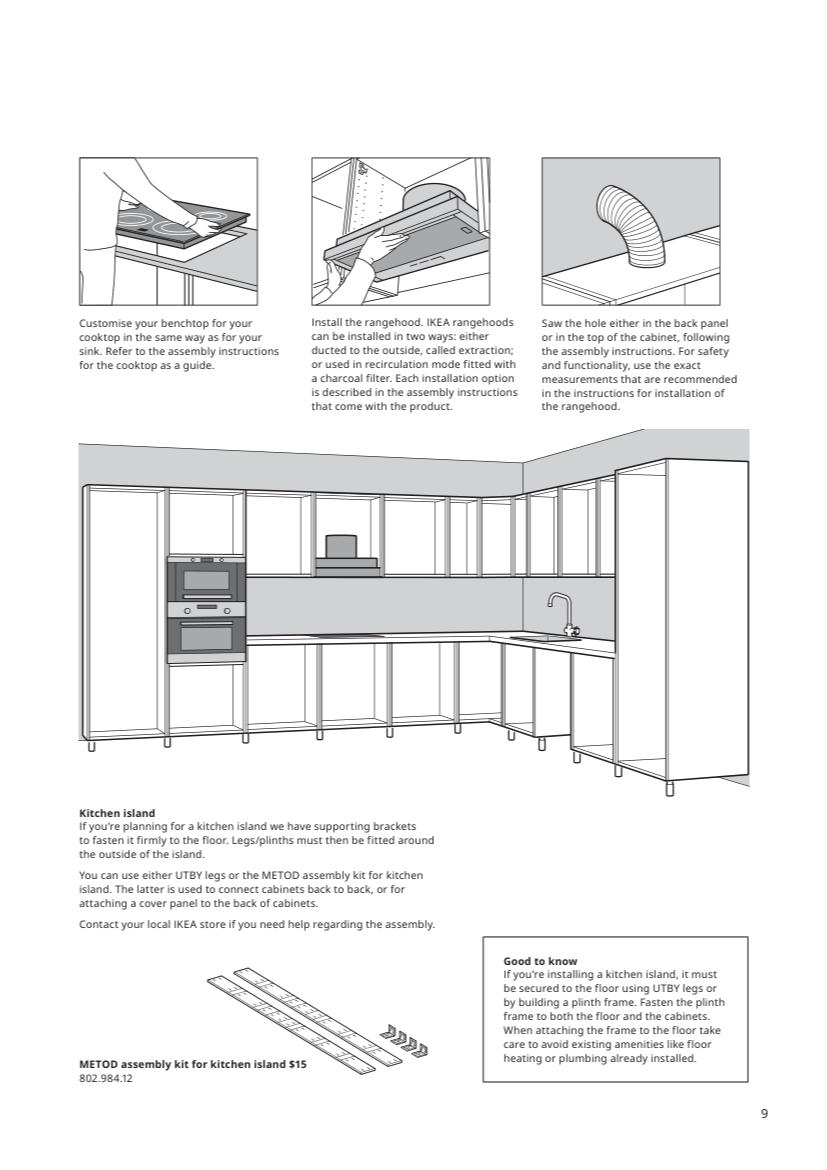

*** Chunk 4 Content ***


*Page 10 content:*


 **Installing your shelves, drawers, doors, knobs and handles**

Now your cabinet frames, benchtops and appliances are in, fit your drawer slides into your cabinets. Remember that the slides for inner drawers and standard drawers are fitted in different ways.

Once the slides are in, fit in the drawers before the doors and shelves. Finish by adding knobs and handles as well as any other internal solutions, like wire baskets.

Note: Always use your assembly instructions for help.

0

0

0

0

0

Fasten your drawer slides, starting with your outer drawers. Outer drawer slides should be attached to the outer row of holes in your cabinet.

Once your outer drawer slides are in, fit your inner drawer slides. The inner drawers slides are fitted to the inner row of holes in your cabinet.

Assemble your doors and drawers.

0

0

0

0 0

0

0

0

0

0 0

0

0

0

0

0 0

0

Attach the hinges for your doors.

Fit drawers and doors to your cabinets.

Align your doors to the correct height and width by adjusting the screws on the hinge plate.

If you're fitting a plinth now is the time to attach it. Follow the assembly instructions for help.

If you are fitting a ventilation grill, place the grill between two pieces of plinth.




*Page 10 Image:*

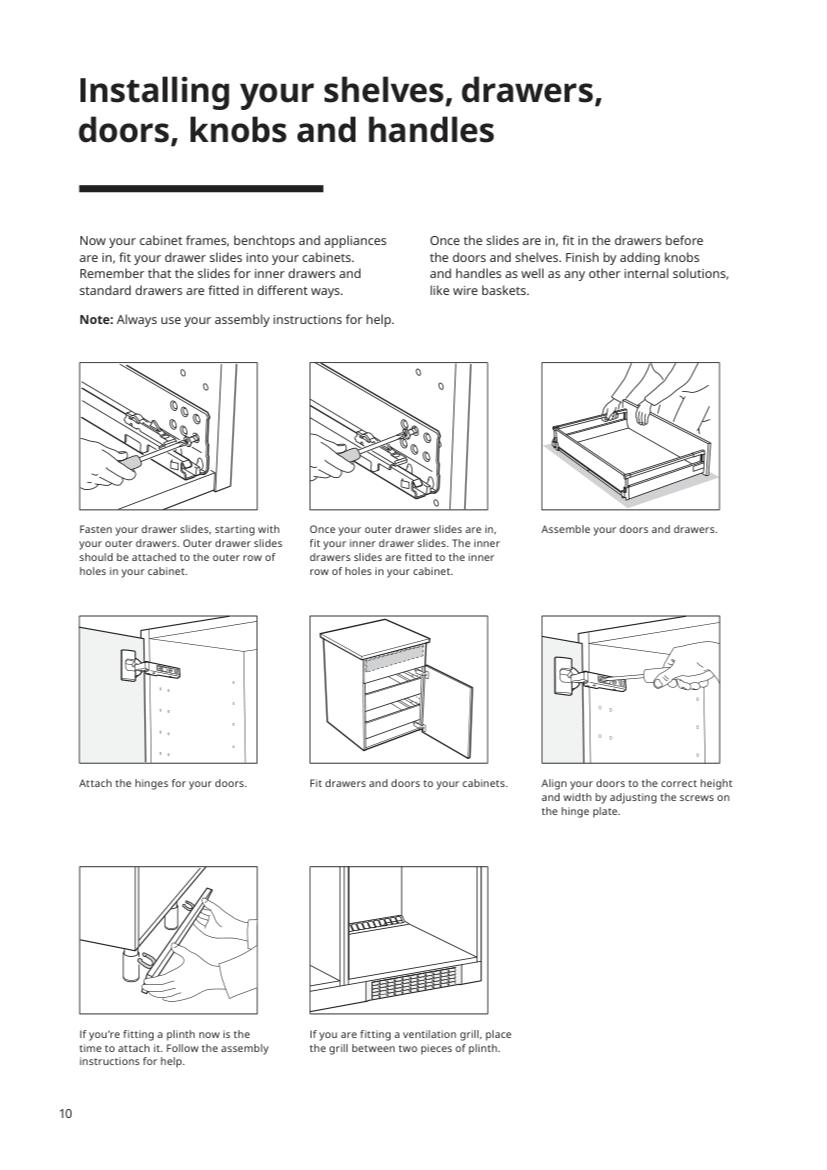


*Page 11 content:*


 **You're done. Congratulations on your new kitchen!**

Time to step back and admire your new kitchen. With a little care and maintenance, your IKEA kitchen will look great for many years to come.


 **Caring for your cabinets**

Clean the doors, cabinet interiors and wood surfaces with a soft, damp cloth. Only use cleaning products intended for these materials. Do not use products that contain ammonia, alcohol, bleach or abrasives. Rinse with clean water, then dry with a clean, dry cloth. Make sure to clean up spills quickly.


 **Keep your sink sparkling**

After each use, wipe the sink clean with a damp cloth or sponge or using a non-abrasive detergent, if necessary. Rinse the bowl with water and then wipe the sink with a dry cloth. Avoid scouring powder, steel wool, or hard objects which can scratch the stainless steel surface. The damp surface can be discoloured if substances containing iron, such as steel wool, nails or gravel, are allowed to remain on it. Discolouration is caused by the foreign material.

O

O [ ]

[ ]


 **Long-lasting benchtops**

Keep your benchtop in top condition by cleaning spills quickly with water and a mild detergent. Be sure to keep the benchtop as dry as possible after use. For wood and solid wood benchtops use STOCKARYD wood treatment oil. The oil protects the wood from marks, stains and cracks, and prevents water from penetrating the surface.




*Page 11 Image:*

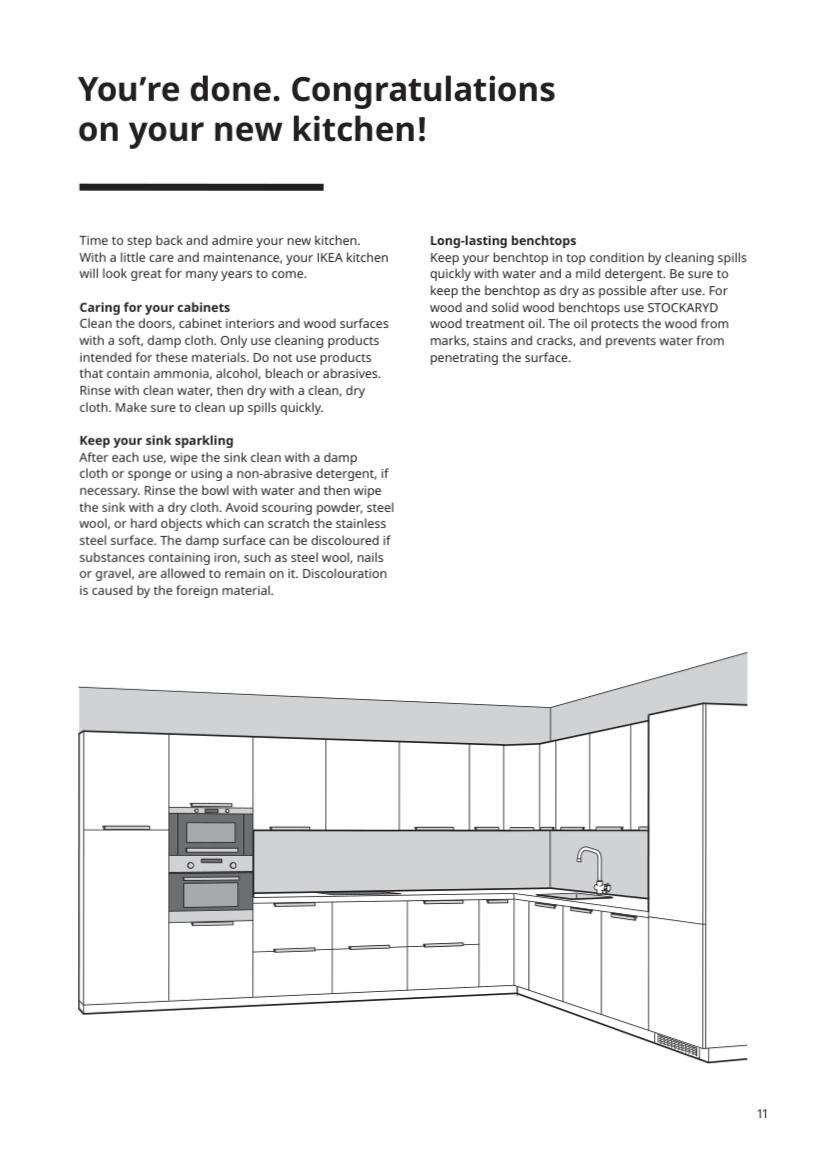


*Page 12 content:*


 **Services**

You can do it all yourself-but you don't have to If you want a little extra help with your purchase, we're happy to lend a hand. Our broad service offer gives you the freedom to choose not only the products that suit you, but how much you'd like to do yourself and how much you want us to do for you.


 **Kitchen planning**

Even on big projects, the little things matter. Discuss your ideas with our team of design professionals and we'll help nail them down in detail.

Delivery Whether you are shopping in-store or online, and no matter how big the purchase, we'll do the heavy lifting and bring it to your preferred location.


 **Click and collect**

Save time on your next purchase. Place your order online, and we'll have it ready to pick up when you arrive.

Installation Need a little help or a lot? For ACT, NSW, QLD and VIC customers, we'll help you to get matched with the best tradespeople to install your new kitchen, bathroom or lighting.

@ Inter IKEA Systems B.V. 2020/2021

*Barcode value:* https://bit.ly/3r3bjK9 (*Barcode kind:* QRCode)

Scan here for more information about our services

For more details about our services, talk to a co-worker at your local IKEA store or visit us at IKEA.com.au/services

Payment options We accept many payment methods, including cards and cash.

Interest-free finance To help you realise your dream today, we offer 50 months interest-free finance to approved customers. Terms and conditions apply. For details see IKEA.com.au/ finance

Returns policy It's OK to change your mind. If you're not totally satisfied with your IKEA purchase, you can return it within 365 days, together with proof of purchase, for a full refund.

IKEA®




*Page 12 Image:*

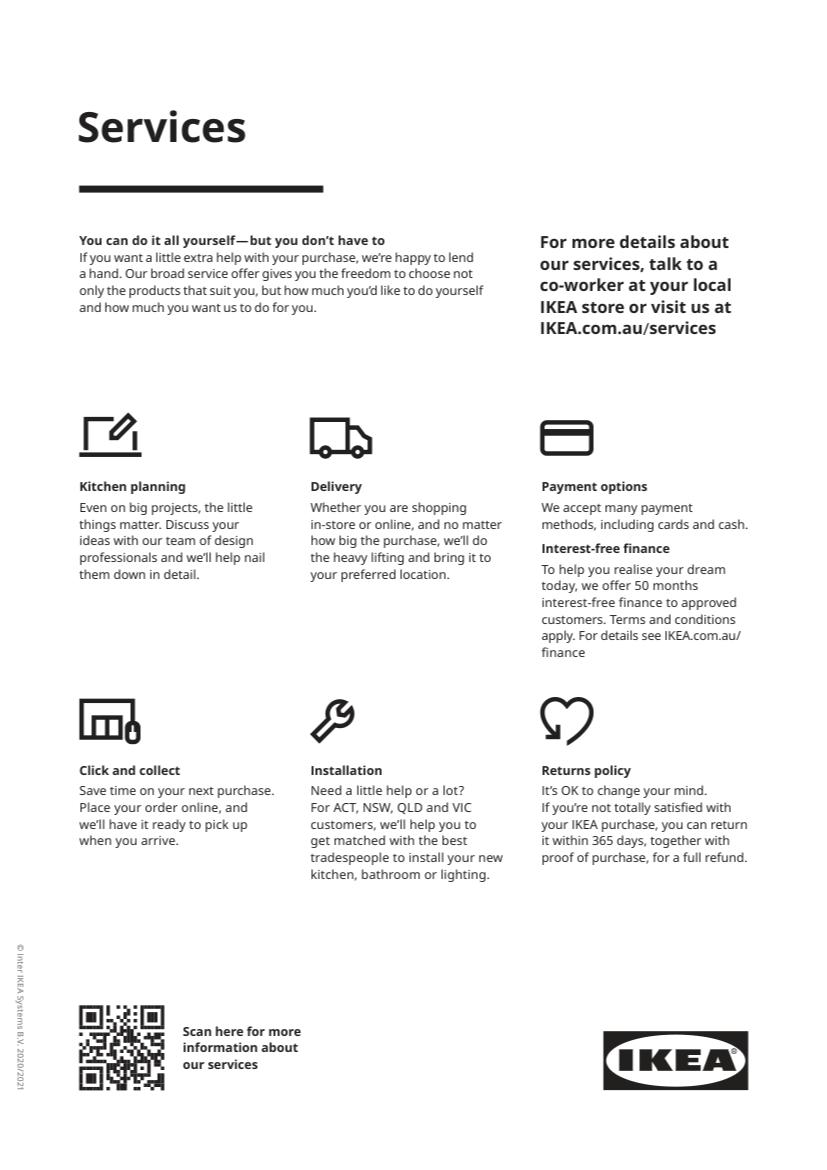

==================== PROCESSING TEST PDF: 'rotated_image_pdf' =========================

Reusing DI result
Output info:

- Number of pages in the file: 1
- Number of content Documents: 3
- Number of content Documents after merging adjacent text Documents: 2
- Number of content chunks after splitting the Documents by page: 1

Printing the content in markdown format
*** Chunk 1 Content ***


*Page 1 content:*

Never look back!




*Page 1 Image:*

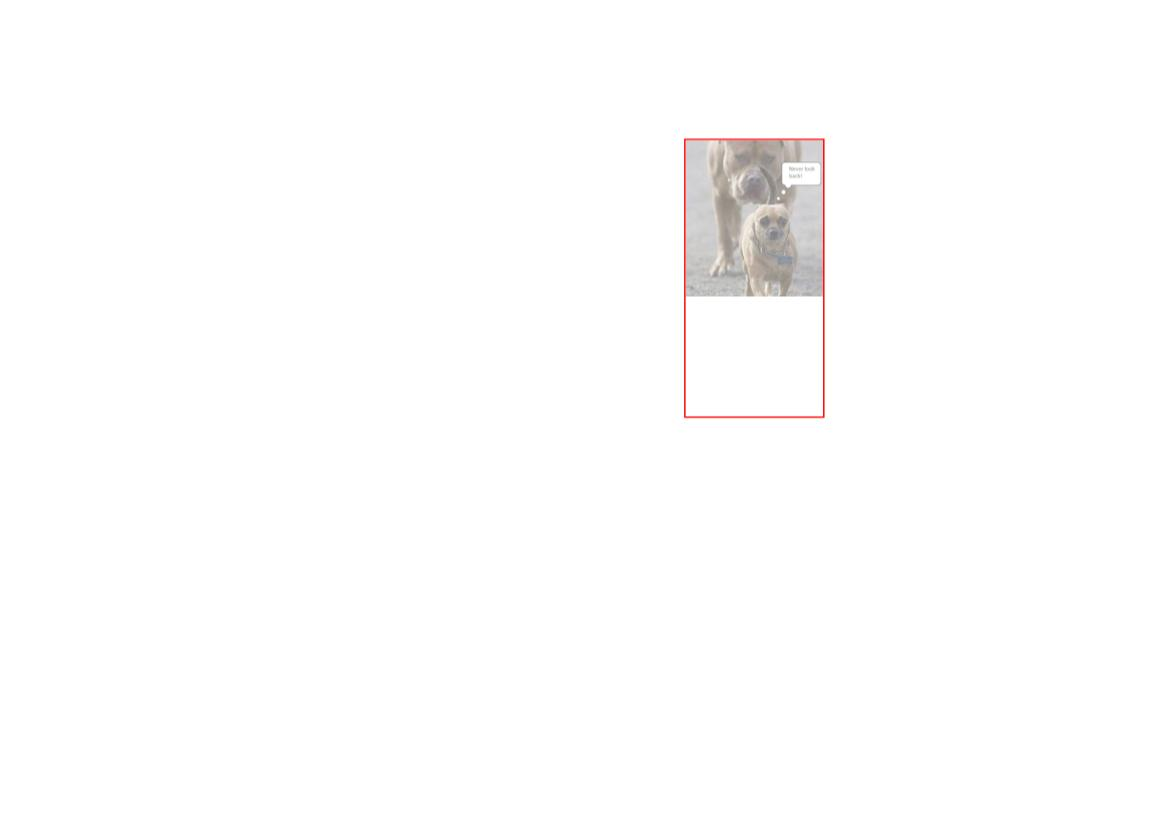

==================== PROCESSING TEST PDF: 'editorial_page' =========================

Reusing DI result
Output info:

- Number of pages in the file: 1
- Number of content Documents: 18
- Number of content Documents after merging adjacent text Documents: 2
- Number of content chunks after splitting the Documents by page: 1

Printing the content in markdown format
*** Chunk 1 Content ***


*Page 1 content:*

EDITORIAL


 **Wissen aus erster Hand**

Reinhard Breuer Chefredakteur

Schöne neue Welten

Unglücklich der Geist, der um Künftiges bangt. »Essais«, Michel de Montaigne (1533-1592)

liebe Spektrum-leser,

unaufhörlich rast die Zukunft auf uns zu und mehr oder weniger gekonnt werfen wir uns in den Strom der Zeit. Zukunft ist implizit auch das Thema dreier Beiträge in dieser Ausgabe: über das weltgrößte Observatorium, die drohende Grippepandemie sowie die Visionen von Ray Kurzweil über den Umbau des Menschen zu einer »Version 2.0«.

Als ich kürzlich in Argentinien an der Einweihungsfeier des Pierre-Auger- Observatoriums zur Beobachtung kosmischer Strahlen teilnahm, sah ich, wie damit auch symbolisch ein Fenster zum Weltall weiter aufgestoßen wurde. Die Mikrogeschosse bringen die Forscher schier zur Verzweiflung: Kein Mensch weiß, woher sie stammen - eines der letzten großen Rätsel der As-

trophysik (S. 12). Doch Ge- NA, IST FERNSEHEN ZU ZWEIT NICHT VIEL SCHÖNER ?! heimnisse sind das Salz der Wissenschaft; und so bildete der Event in Argentinien nur einen Mosaikstein innerhalb der gerade laufenden Entde- ckung des heißen Kosmos, angetrieben durch die Ge- burt der Teilchenastrophysik OH im letzten Jahrzehnt. Das meint neuartige Detektoren und Observatorien, mit de- nen derzeit nach Gravitations- wellen, nach der kosmischen »Dunklen Energie« und nach Hochenergie-Gammastrahlen gespäht und re- volutionäre Physik betrieben wird - mit Neutrinos und der direkten Bestim- mung ihrer Masse. Ein neues Bild des Universums zeichnet sich ab.

00

Währenddessen bedrängen uns auf der Erde andere Fragen, die gleichfalls drohen - oder versprechen, unsere Zukunft zu dominieren. Es ist nicht die Frage, ob, sondern nur, wann ein hochansteckendes Influenzavirus die nächste Pande- mie auslöst - darin sind sich Epidemiologen einig. Wie die Pläne aussehen, um dieser globalen Bedrohung zu begegnen, berichten wir ab S. 72.

Mit solchen Details gibt sich Ray Kurzweil bei der Betrachtung der Zukunft nicht ab. Dem amerikanischen Erfinder und Visionär geht es darum, sich (und uns) auszumalen, wie Technologien, die sich exponentiell entwickeln, in we- nigen Jahrzehnten den Menschen verändern werden. Kurzweil, dessen Essay ich durchaus auch als Polemik verstehe, weitet seine vergangenen Prophe- tien diesmal auf die biologische Neugestaltung des menschlichen Körpers und seines Gehirns aus. Dass er mit allem Recht hat, bezweifle ich. Aber wenn auch nur ein Viertel davon eintreffen wird, dann gehen wir, wie die Chi- nesen gerne sagen, »interessanten Zeiten« entgegen (S. 100). Herzlich Ihr

Reinhard Breuer

spektrumdirekt Die Wissenschaftszeitung im Internet

Die Redaktion von spektrumdirekt informiert Sie online schnell, fundiert und verständlich über den Stand der Forschung.

spektrumdirekt




*Page 1 Image:*

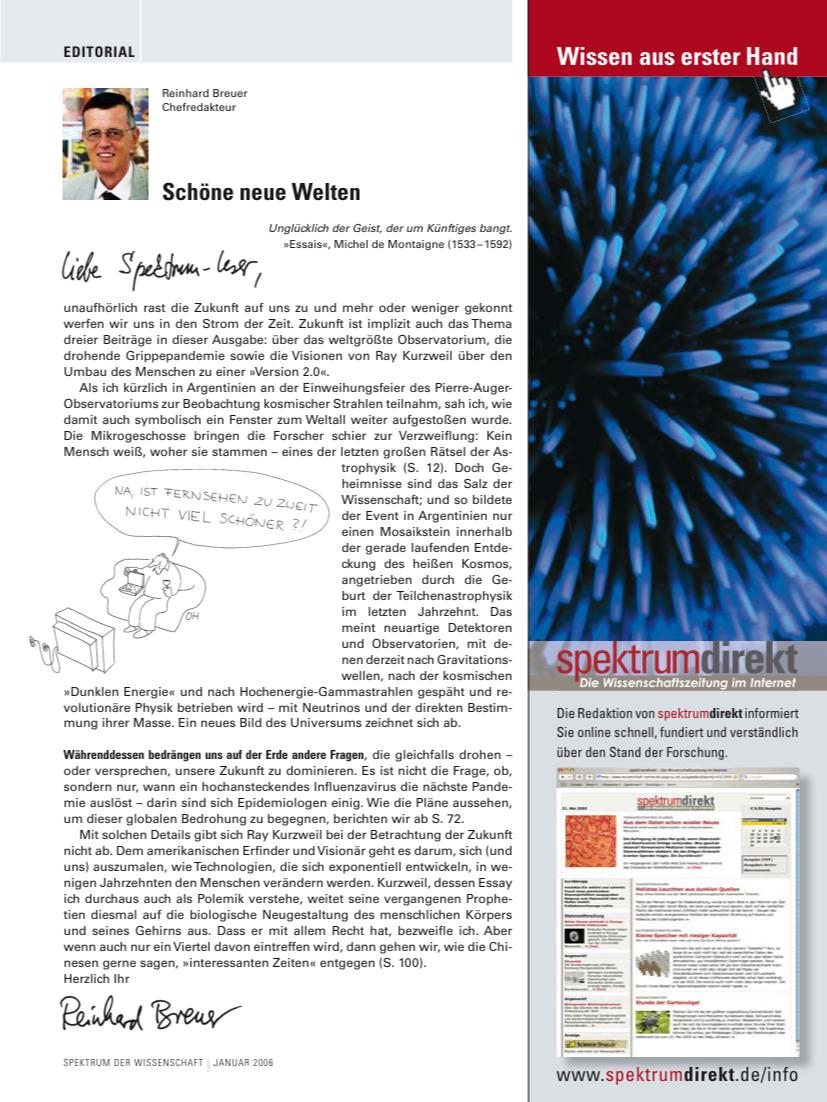

==================== PROCESSING TEST PDF: 'multicolumn_pdf' =========================

Reusing DI result
Output info:

- Number of pages in the file: 3
- Number of content Documents: 26
- Number of content Documents after merging adjacent text Documents: 6
- Number of content chunks after splitting the Documents by page: 1

Printing the content in markdown format
*** Chunk 1 Content ***


*Page 1 content:*


 **Two-Column Document with Lorem Ipsum**


 **Your Name January 3, 2024**


 **Abstract**

This is a sample document with two columns filled with Lorem Ipsum text.

Lorem ipsum dolor sit amet, consectetuer adip- iscing elit. Ut purus elit, vestibulum ut, placerat ac, adipiscing vitae, felis. Curabitur dictum gravida mauris. Nam arcu libero, nonummy eget, con- sectetuer id, vulputate a, magna. Donec vehicula augue eu neque. Pellentesque habitant morbi tris- tique senectus et netus et malesuada fames ac turpis egestas. Mauris ut leo. Cras viverra metus rhon- cus sem. Nulla et lectus vestibulum urna fringilla ultrices. Phasellus eu tellus sit amet tortor gravida placerat. Integer sapien est, iaculis in, pretium quis, viverra ac, nunc. Praesent eget sem vel leo ultri- ces bibendum. Aenean faucibus. Morbi dolor nulla, malesuada eu, pulvinar at, mollis ac, nulla. Cur- abitur auctor semper nulla. Donec varius orci eget risus. Duis nibh mi, congue eu, accumsan eleifend, sagittis quis, diam. Duis eget orci sit amet orci dig- nissim rutrum.

Nam dui ligula, fringilla a, euismod sodales, sollic- itudin vel, wisi. Morbi auctor lorem non justo. Nam lacus libero, pretium at, lobortis vitae, ultricies et, tellus. Donec aliquet, tortor sed accumsan biben- dum, erat ligula aliquet magna, vitae ornare odio metus a mi. Morbi ac orci et nisl hendrerit mollis. Suspendisse ut massa. Cras nec ante. Pellentesque a nulla. Cum sociis natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Aliquam tincidunt urna. Nulla ullamcorper vestibulum turpis. Pellentesque cursus luctus mauris.

Nulla malesuada porttitor diam. Donec felis erat, congue non, volutpat at, tincidunt tristique, libero. Vivamus viverra fermentum felis. Donec nonummy

pellentesque ante. Phasellus adipiscing semper elit. Proin fermentum massa ac quam. Sed diam turpis, molestie vitae, placerat a, molestie nec, leo. Maece- nas lacinia. Nam ipsum ligula, eleifend at, accumsan nec, suscipit a, ipsum. Morbi blandit ligula feugiat magna. Nunc eleifend consequat lorem. Sed lacinia nulla vitae enim. Pellentesque tincidunt purus vel magna. Integer non enim. Praesent euismod nunc eu purus. Donec bibendum quam in tellus. Nullam cursus pulvinar lectus. Donec et mi. Nam vulpu- tate metus eu enim. Vestibulum pellentesque felis eu massa.

Quisque ullamcorper placerat ipsum. Cras nibh. Morbi vel justo vitae lacus tincidunt ultrices. Lorem ipsum dolor sit amet, consectetuer adipiscing elit. In hac habitasse platea dictumst. Integer tempus conva- llis augue. Etiam facilisis. Nunc elementum fermen- tum wisi. Aenean placerat. Ut imperdiet, enim sed gravida sollicitudin, felis odio placerat quam, ac pul- vinar elit purus eget enim. Nunc vitae tortor. Proin tempus nibh sit amet nisl. Vivamus quis tortor vitae risus porta vehicula.

Fusce mauris. Vestibulum luctus nibh at lectus. Sed bibendum, nulla a faucibus semper, leo velit ul- tricies tellus, ac venenatis arcu wisi vel nisl. Vestibu- lum diam. Aliquam pellentesque, augue quis sagittis posuere, turpis lacus congue quam, in hendrerit risus eros eget felis. Maecenas eget erat in sapien mattis porttitor. Vestibulum porttitor. Nulla facilisi. Sed a turpis eu lacus commodo facilisis. Morbi fringilla, wisi in dignissim interdum, justo lectus sagittis dui, et vehicula libero dui cursus dui. Mauris tempor ligula sed lacus. Duis cursus enim ut augue. Cras ac magna. Cras nulla. Nulla egestas. Curabitur a leo. Quisque egestas wisi eget nunc. Nam feugiat




*Page 1 Image:*

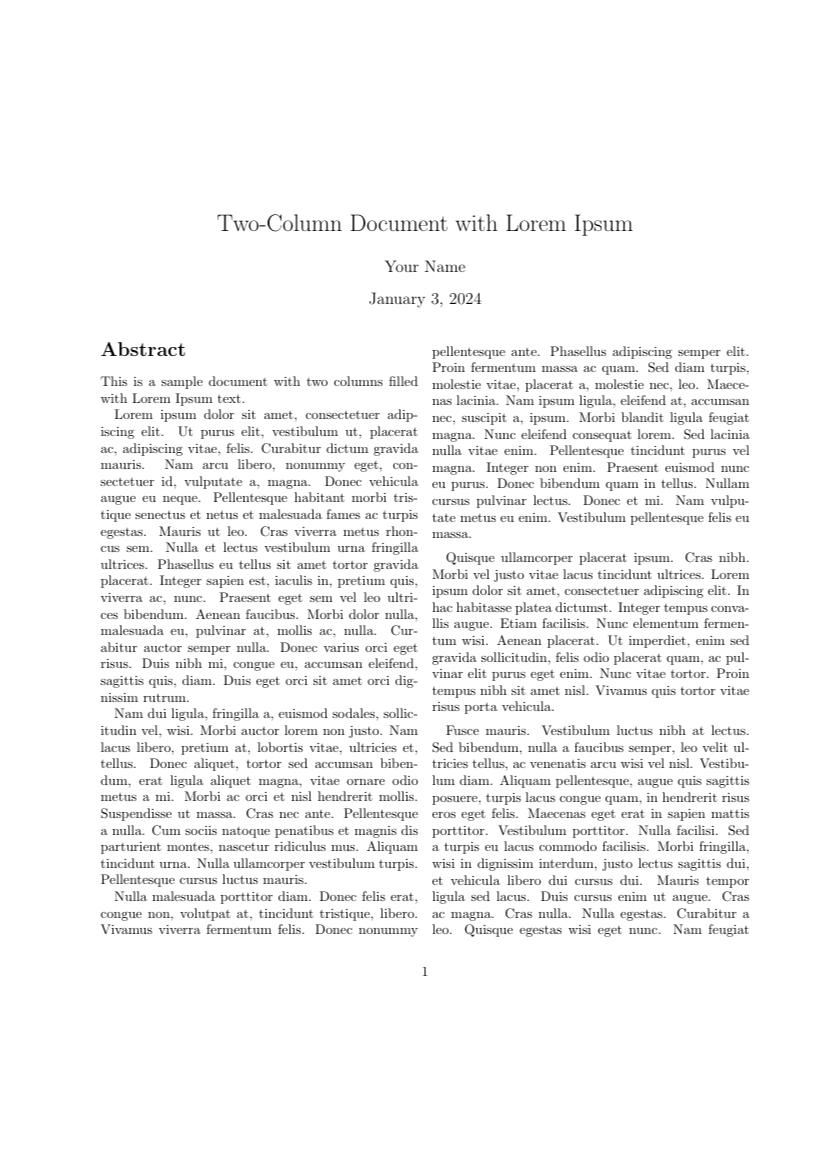


*Page 2 content:*

lacus vel est. Curabitur consectetuer.

Suspendisse vel felis. Ut lorem lorem, interdum eu, tincidunt sit amet, laoreet vitae, arcu. Aenean faucibus pede eu ante. Praesent enim elit, rutrum at, molestie non, nonummy vel, nisl. Ut lectus eros, malesuada sit amet, fermentum eu, sodales cursus, magna. Donec eu purus. Quisque vehicula, urna sed ultricies auctor, pede lorem egestas dui, et convallis elit erat sed nulla. Donec luctus. Curabitur et nunc. Aliquam dolor odio, commodo pretium, ultricies non, pharetra in, velit. Integer arcu est, nonummy in, fer- mentum faucibus, egestas vel, odio.

Sed commodo posuere pede. Mauris ut est. Ut quis purus. Sed ac odio. Sed vehicula hendrerit sem. Duis non odio. Morbi ut dui. Sed accumsan risus eget odio. In hac habitasse platea dictumst. Pellen- tesque non elit. Fusce sed justo eu urna porta tin- cidunt. Mauris felis odio, sollicitudin sed, volutpat a, ornare ac, erat. Morbi quis dolor. Donec pellen- tesque, erat ac sagittis semper, nunc dui lobortis pu- rus, quis congue purus metus ultricies tellus. Proin et quam. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos hymenaeos. Prae- sent sapien turpis, fermentum vel, eleifend faucibus, vehicula eu, lacus.

Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Donec odio elit, dictum in, hendrerit sit amet, egestas sed, leo. Praesent feugiat sapien aliquet odio. Inte- ger vitae justo. Aliquam vestibulum fringilla lorem. Sed neque lectus, consectetuer at, consectetuer sed, eleifend ac, lectus. Nulla facilisi. Pellentesque eget lectus. Proin eu metus. Sed porttitor. In hac habitasse platea dictumst. Suspendisse eu lectus. Ut mi mi, lacinia sit amet, placerat et, mollis vitae, dui. Sed ante tellus, tristique ut, iaculis eu, malesuada ac, dui. Mauris nibh leo, facilisis non, adipiscing quis, ultrices a, dui.

Morbi luctus, wisi viverra faucibus pretium, nibh est placerat odio, nec commodo wisi enim eget quam. Quisque libero justo, consectetuer a, feugiat vitae, porttitor eu, libero. Suspendisse sed mauris vitae elit sollicitudin malesuada. Maecenas ultricies eros sit amet ante. Ut venenatis velit. Maecenas sed mi eget dui varius euismod. Phasellus aliquet volutpat odio. Vestibulum ante ipsum primis in faucibus orci

luctus et ultrices posuere cubilia Curae; Pellentesque sit amet pede ac sem eleifend consectetuer. Nullam elementum, urna vel imperdiet sodales, elit ipsum pharetra ligula, ac pretium ante justo a nulla. Cur- abitur tristique arcu eu metus. Vestibulum lectus. Proin mauris. Proin eu nunc eu urna hendrerit fau- cibus. Aliquam auctor, pede consequat laoreet var- ius, eros tellus scelerisque quam, pellentesque hen- drerit ipsum dolor sed augue. Nulla nec lacus.

Suspendisse vitae elit. Aliquam arcu neque, ornare in, ullamcorper quis, commodo eu, libero. Fusce sagittis erat at erat tristique mollis. Maecenas sapien libero, molestie et, lobortis in, sodales eget, dui. Morbi ultrices rutrum lorem. Nam elementum ullam- corper leo. Morbi dui. Aliquam sagittis. Nunc plac- erat. Pellentesque tristique sodales est. Maecenas imperdiet lacinia velit. Cras non urna. Morbi eros pede, suscipit ac, varius vel, egestas non, eros. Prae- sent malesuada, diam id pretium elementum, eros sem dictum tortor, vel consectetuer odio sem sed wisi.




*Page 2 Image:*

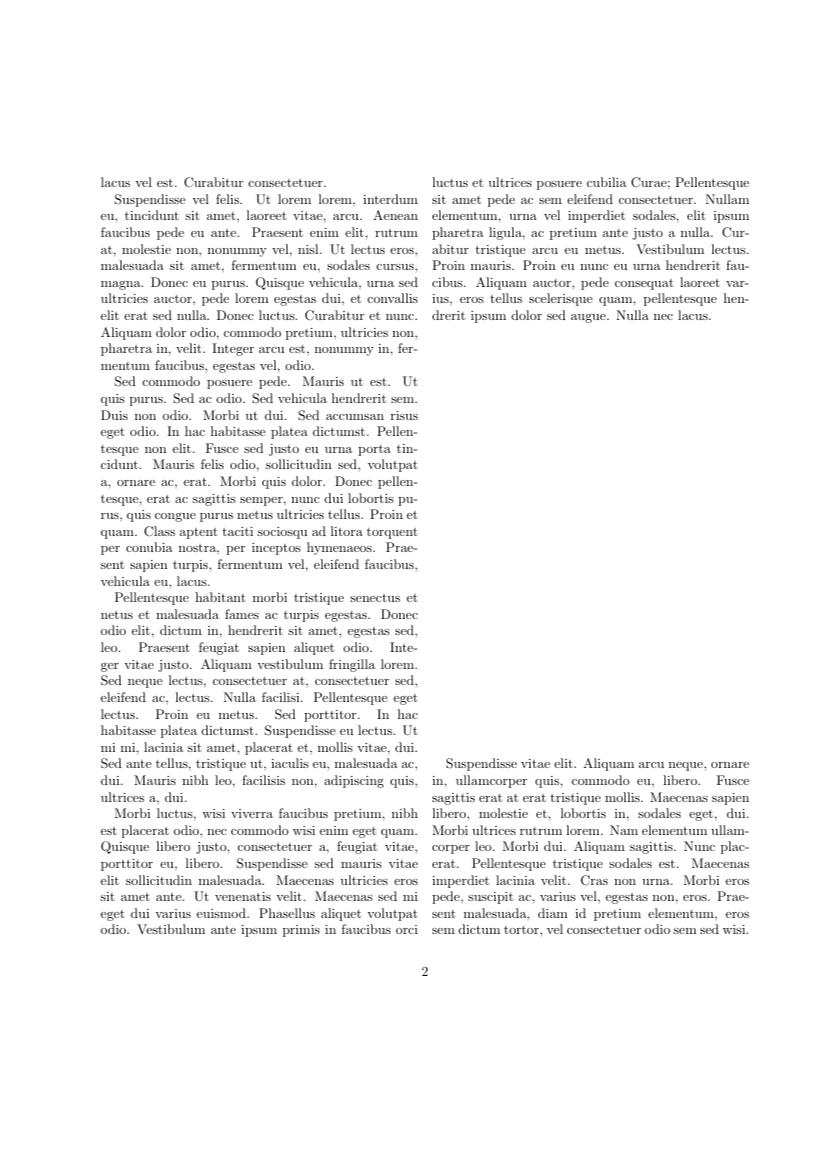


*Page 3 content:*

Table 1: EU Countries Information

**Table 1 Info**

*Table Content:*


| Country        |   Population (millions) | Area (km2)   | Capital    | Official Language     |
|----------------|-------------------------|--------------|------------|-----------------------|
| Austria        |                     8.9 | 83,879       | Vienna     | German                |
| Belgium        |                    11.5 | 30,689       | Brussels   | Dutch, French, German |
| Czech Republic |                    10.7 | 78,866       | Prague     | Czech                 |
| Denmark        |                     5.8 | 42,951       | Copenhagen | Danish                |
| Finland        |                     5.5 | 338,424      | Helsinki   | Finnish, Swedish      |






*Page 3 Image:*

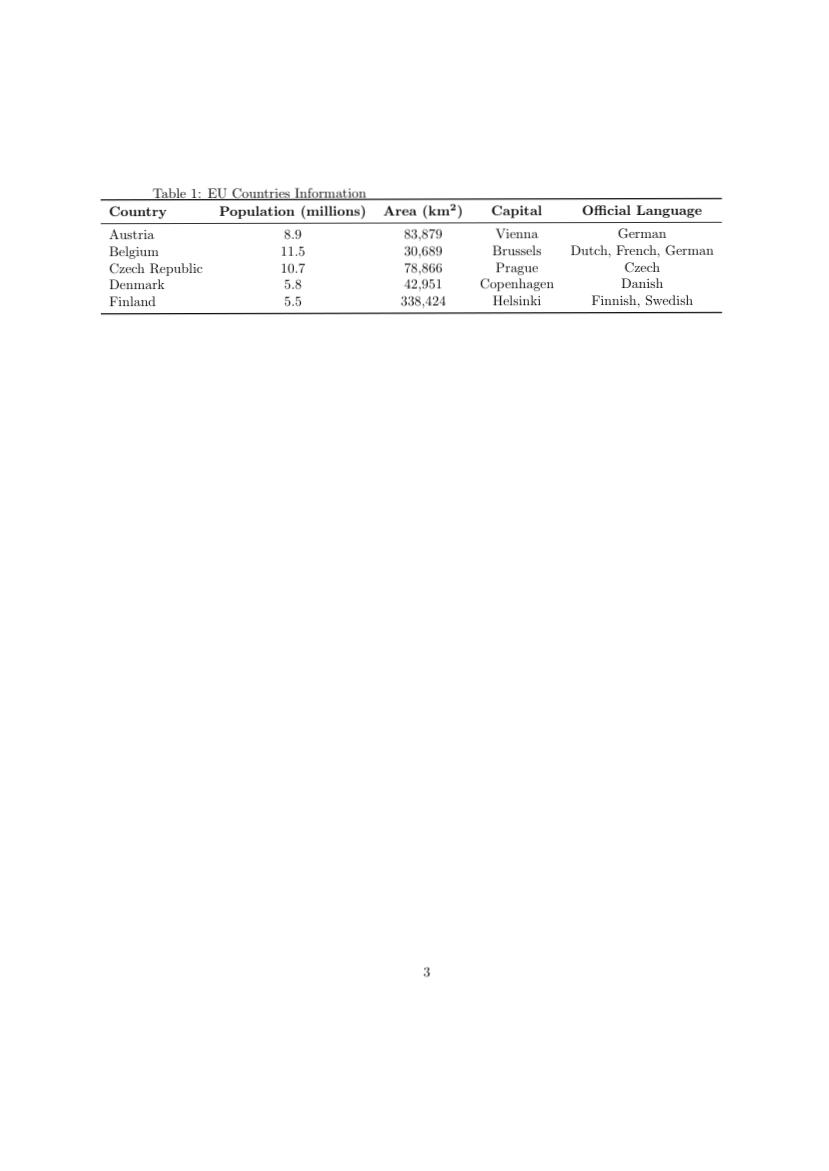

==================== PROCESSING TEST PDF: 'rotated_proof_of_delivery_pdf' =========================

Reusing DI result
Output info:

- Number of pages in the file: 1
- Number of content Documents: 33
- Number of content Documents after merging adjacent text Documents: 2
- Number of content chunks after splitting the Documents by page: 1

Printing the content in markdown format
*** Chunk 1 Content ***


*Page 1 content:*

MORRISON SUPPLY COMPANY a MORSCO company

BRANCH: 1001 ABILENE 242 SOUTH TREADAWAY BLVD ABILENE TX 79602-1747 Phone: 325-677-8174


 **INVOICE**

**Table 1 Info**

*Table Content:*


| INVOICE DATE   | INVOICE NUMBER   |
|----------------|------------------|
| 02/28/2017     | S101589595.001   |



**Table 2 Info**

*Table Content:*


| PLEASE REMIT TO:                   | PAGE NO.    |
|------------------------------------|-------------|
| MORRISON SUPPLY COMPANY PO BOX 309 |             |
| FORT WORTH TX 76101-0309           | Page 1 of 1 |
| Phone: 817-484-4676                |             |



BILL TO:

ANSON PARK I

2934 OLD ANSON RD

ABILENE TX 79603-1838

SHIP TO:

ANSON PARK I SHOP

2934 OLD ANSON RD

ABILENE TX 79603-1838

**Table 3 Info**

*Table Content:*


|   CUSTOMER NUMBER | CUSTOMER PO NUMBER   | JOB NAME / RELEASE NUMBER   | SALESPERSON   |
|-------------------|----------------------|-----------------------------|---------------|
|             64481 | Serv Chrg            |                             |               |



**Table 4 Info**

*Table Content:*


| WRITER   | SHIP VIA   | TERMS         | SHIP DATE   | ORDER DATE   |
|----------|------------|---------------|-------------|--------------|
|          | ACCOUNTING | NET 15TH PROX | 02/28/2017  | 02/28/2017   |



**Table 5 Info**

*Table Content:*


| ORDER QTY   | SHIP QTY   | PRODUCT ID   | DESCRIPTION                                 |   UNIT PRICE |   EXT PRICE |
|-------------|------------|--------------|---------------------------------------------|--------------|-------------|
| 1ea         | 1ea        |              | SERVICE CHARGE This Finance Charge is being |         6.81 |        6.81 |



SAVE TIME $

SAVE TIME AND MONEY BY PAYING ONLINE

Our goal is to make it easy for you to manage the invoices you receive from us. For the ultimate in convenience try our online bill payment portal. You will be notified by email when new invoices are posted. You can view, print, $ download and pay your invoices online. Save time and money by going paperless. Visit http://www.Morsco.com to enroll.

SAVE MONEY

For TERMS and CONDITIONS, See "TERMS PAGE."

Invoice is due by 03/15/2017. All claims for shortages or errors must be made at once, returns require written authorization and are subject to handling charges. Special orders are non-returnable.

**Table 6 Info**

*Table Content:*


| <!-- -->    |   <!-- --> |
|-------------|------------|
| Subtotal    |       6.81 |
| S&H Charges |       0    |
| Tax         |       0    |
| Payments    |       0    |
| Amount Due  |       6.81 |



**Table 7 Info**

*Table Content:*


| ('TO VIEW ONLINE', 'ENROLLMENT TOKEN')   |   ('http:/morsco.billtrust.com', 'MKV DMB WVR') |
|------------------------------------------|-------------------------------------------------|
| ACCOUNT NUMBER                           |                                           10470 |






*Page 1 Image:*

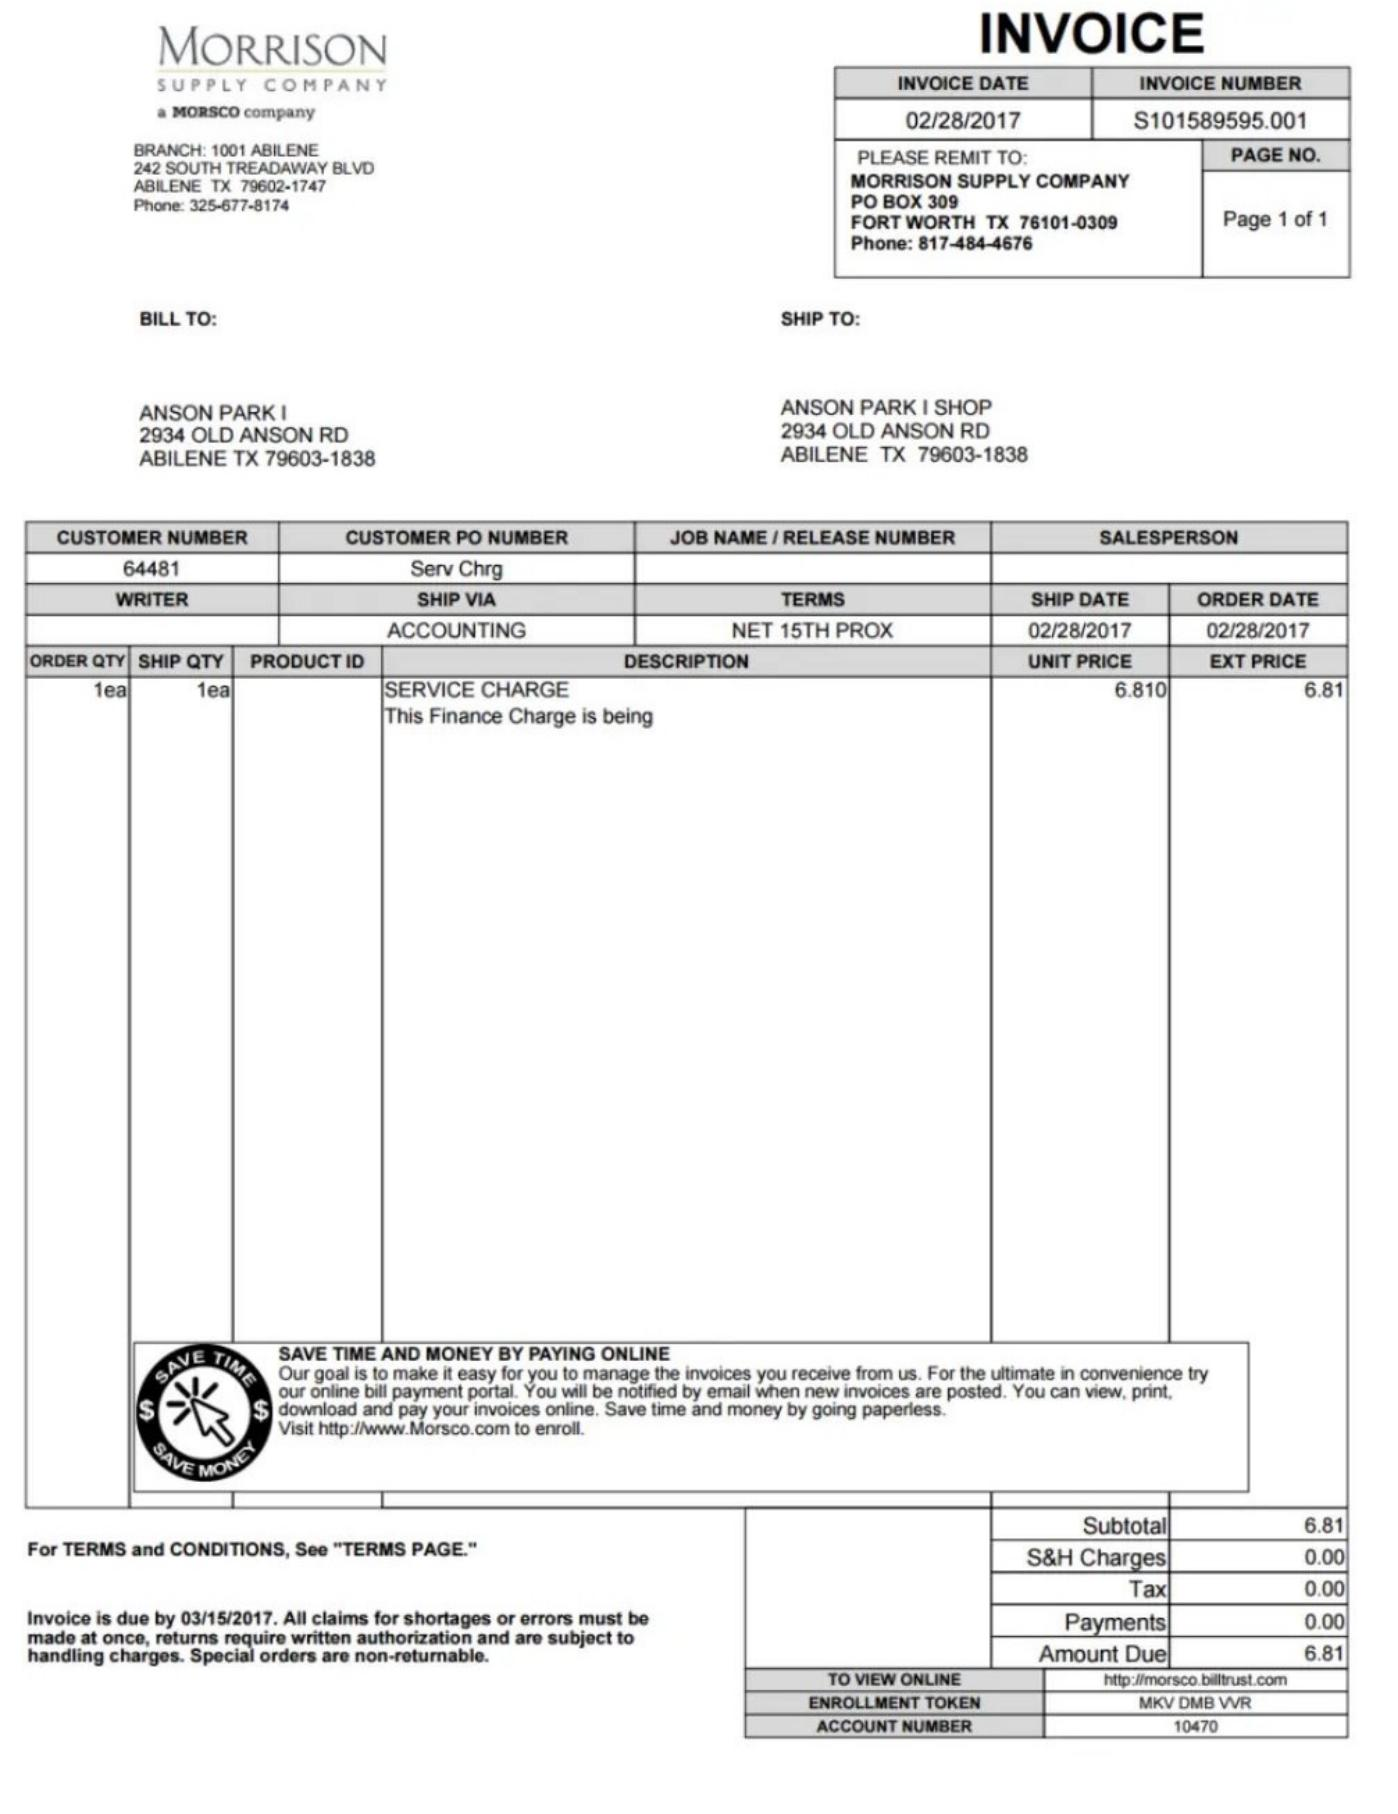

In [112]:
# Set the list of sample PDFs to process
# TEST_PDF_NAMES = ["rotated_proof_of_delivery_pdf", "ikea"] # Select specific test PDFs
TEST_PDF_NAMES = list(doc_intelligence_test_files.keys()) # Use all test PDFs

# Set the max number of elements to process before stopping (this prevents the notebook from getting too long)
BREAK_AFTER_ELEMENT_IDX = 10000

for test_pdf_name in TEST_PDF_NAMES:
    print(f"==================== PROCESSING TEST PDF: '{test_pdf_name}' =========================\n")
    # Load the PDF with PyMuPDF and convert the pages to images. We need to do this to get the images for the pages and figures.
    pdf_url = doc_intelligence_test_files[test_pdf_name].url_source
    pdf = load_pymupdf_pdf(pdf_path=None, pdf_url=pdf_url)
    doc_page_imgs = extract_pdf_page_images(pdf, img_dpi=100, starting_idx=1)

    # Get Doc Intelligence result
    di_result = get_analyze_document_result(
        sample_pdf_file_info=doc_intelligence_test_files[test_pdf_name],
        di_client=di_client,
        model_id=DOC_INTEL_MODEL_ID,
        features=enabled_features,
    )

    # Process the API response with the processor
    processed_content_docs = doc_intel_result_processor.process_analyze_result(
        di_result,
        doc_page_imgs=doc_page_imgs, 
        on_error="ignore", 
        break_after_element_idx=BREAK_AFTER_ELEMENT_IDX
    )

    # Split the results into chunks
    page_chunked_content_docs = chunk_splitter.split_document_list(processed_content_docs)

    # By default, each element outputs a separate data class. Converting these to LLM messages would
    # result in hundreds or thousands of messages for each PDF. We can merge adjacent text elements together
    # to reduce their quantity prior to converting them into LLM messages.
    merged_subchunk_content_docs = doc_intel_result_processor.merge_adjacent_text_content_docs(page_chunked_content_docs, default_text_merge_separator="\n\n")

    print("Output info:")
    print("\n- Number of pages in the file:", len(doc_page_imgs))
    print("- Number of content Documents:", len(processed_content_docs))
    print("- Number of content Documents after merging adjacent text Documents:", sum([len(l) for l in merged_subchunk_content_docs]))
    print("- Number of content chunks after splitting the Documents by page:", len(page_chunked_content_docs))

    # Convert content to OpenAI messages
    all_content_openai_message = convert_processed_di_docs_to_openai_message(processed_content_docs, role="user")
    first_chunk_openai_message = convert_processed_di_docs_to_openai_message(merged_subchunk_content_docs[0], role="user")
    
    # Optionally print the OpenAI messages
    # print("\nAll content OpenAI messages:")
    # all_content_openai_message
    # print("First chunk OpenAI messages:")
    # first_chunk_openai_message

    # Print content in the notebook
    print("\nPrinting the content in markdown format")
    for chunk_num, chunk_docs in enumerate(merged_subchunk_content_docs, start=1):
        print(f"*** Chunk {chunk_num} Content ***")
        md(convert_processed_di_docs_to_markdown(chunk_docs, default_text_merge_separator="\n"))

# Send the document contents to Azure OpenAI
With the document now processed, we can easily convert the output into messages that are ready for processing with Azure OpenAI.

In [9]:
from openai import AzureOpenAI

AOAI_LLM_DEPLOYMENT = os.getenv("AOAI_LLM_DEPLOYMENT")
AOAI_ENDPOINT = os.getenv("AOAI_ENDPOINT")
AOAI_API_KEY = os.getenv("AOAI_API_KEY")

aoai_client = AzureOpenAI(
    azure_endpoint=AOAI_ENDPOINT,
    azure_deployment=AOAI_LLM_DEPLOYMENT,
    api_key=AOAI_API_KEY,
    api_version="2024-06-01",
    timeout=30,
    max_retries=0,
)

In [10]:
messages = [
    {
        "role": "system",
        "content": "Please summarize the content of the following file into 100 words or less.",
    },
    first_chunk_openai_message,
]
response = aoai_client.chat.completions.create(
    messages=messages,
    model=AOAI_LLM_DEPLOYMENT
)
print(response.choices[0].message.content)

The METOD Kitchen Installation Guide by IKEA offers step-by-step instructions for preparing and installing a new kitchen. It advises checking all parts upon delivery and provides a detailed list of necessary tools and materials, such as a spirit level, measuring tape, screwdriver, and electric drill. The guide emphasizes safety, suggesting the use of safety glasses when using power tools and recommending hiring a qualified professional for certain tasks. It encourages planning and proper storage of kitchen parts before beginning installation.
